# **Modelado Predictivo de la Tasa de Natalidad Trimestral a Nivel Departamental**



Este notebook implementa el pipeline completo de Machine Learning para la predicción trimestral de tasas de natalidad departamental en el Perú. Incluye preprocesamiento avanzado de datos del Registro de Nacidos Vivos (2015-2025), ingeniería de características espacio-temporales, entrenamiento comparativo de múltiples algoritmos (Regresión Lineal, KNN, Árboles, Random Forest, XGBoost) y análisis exhaustivo de resultados. El modelo XGBoost demostró el mejor desempeño (R2=0.91), identificando patrones temporales (53.08%) y heterogeneidad geográfica (38.77%) como los principales predictores, con análisis detallado del impacto COVID-19 y características departamentales clave.

## **1. Configuración y Carga de datos**

### **1.1. Configuración inicial**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Librerías:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

### **1.2. Carga y preparación de datos**

In [ ]:
# =============================================================================
# Fuente: Plataforma Nacional de Datos Abiertos del Perú
# Dataset: Registros de Nacidos Vivos en el Perú (2015-2025)
# Enlace: https://www.datosabiertos.gob.pe/dataset/registros-de-nacidos-vivos-en-el-per%C3%BA-2015%E2%80%932025
# =============================================================================

#Cargar el dataset y analizar filas dañadas
df_nacimientos = pd.read_csv('CNV_MINSA_4782338_CORTE_310825.csv', delimiter=';', on_bad_lines='skip',dtype={'Num_embar_madre': str})

# Diccionario de renombrado de columnas
df_nacimientos.rename(columns={
    'FecNac_Año': 'Año_Nacimiento',
    'FecNac_Mes': 'Mes_Nacimiento',
    'PESO_NACIDO': 'Peso_Nacido',
    'TALLA_NACIDO': 'Talla_Nacido',
    'DUR_EMB_PARTO': 'Duracion_Embarazo',
    'Condicion_Parto': 'Condicion_Parto',
    'sexo_nacido': 'Sexo_Nacido',
    'Tipo_Parto': 'Tipo_Parto',
    'Edad_Madre': 'Edad_Madre',
    'Estado_Civil': 'Estado_Civil_Madre',
    'Nivel_Intrucción_Madre': 'Nivel_Instruccion_Madre',
    'DESC_OCUPACION': 'Ocupacion_Madre',
    'Num_embar_madre': 'Numero_Embarazos_Madre',
    'Hijos_vivo_madre': 'Hijos_Vivos_Madre',
    'Hijos_fallec_madre': 'Hijos_Fallecidos_Madre',
    'nacmuer_abort_madre': 'Abortos_Madre',
    'Pais_Madre': 'Pais_Madre',
    'IdUbigeoInei': 'Codigo_Ubigeo',
    'Ipress': 'Ipress_Hospital',
    'Lugar_Nacido': 'Lugar_Nacimiento',
    'Atiende_Parto': 'Atiende_Parto',
    'Financiador_Parto': 'Financiador_Parto'
}, inplace=True)

# Vista preliminar de los datos
df_nacimientos.head(7)

Año_Nacimiento  Mes_Nacimiento  Peso_Nacido  Talla_Nacido  \
0            2021               1         3425          51.4   
1            2021               1         3320          48.0   
2            2021               1         3200          50.0   
3            2020              10         3850          51.0   
4            2021               1         3990          51.0   
5            2021               1         3440          49.0   
6            2021               1         3480          51.0   

   Duracion_Embarazo Condicion_Parto Sexo_Nacido Tipo_Parto  Edad_Madre  \
0                 41         CESAREA    FEMENINO      UNICO          36   
1                 40        EUTOCICO    FEMENINO      UNICO          35   
2                 39         CESAREA   MASCULINO      UNICO          32   
3                 39        EUTOCICO   MASCULINO      UNICO          34   
4                 38         CESAREA   MASCULINO      UNICO          33   
5                 38        EUTOCICO   MASCULINO      UNICO          20   
6                 38         CESAREA    FEMENINO      UNICO          31   

  Estado_Civil_Madre  ... Numero_Embarazos_Madre Hijos_Vivos_Madre  \
0            SOLTERO  ...                    >=5                 4   
1            SOLTERO  ...                      3                 3   
2            SOLTERO  ...                      4                 2   
3            SOLTERO  ...                      4                 3   
4         DIVORCIADO  ...                      3                 3   
5            SOLTERO  ...                      2                 2   
6            SOLTERO  ...                      2                 1   

  Hijos_Fallecidos_Madre Abortos_Madre Pais_Madre Codigo_Ubigeo  \
0                     -1      11 a más       PERU        200301   
1                     -1       NINGUNO       PERU        130102   
2                     -1             2       PERU        120607   
3                     -1             1       PERU        130205   
4                     -1       NINGUNO       PERU         70101   
5                     -1       NINGUNO       PERU         90206   
6                     -1             1       PERU        150132   

  Ipress_Hospital          Lugar_Nacimiento           Atiende_Parto  \
0            2161  ESTABLECIMIENTO DE SALUD  MEDICO GINECO-OBSTETRA   
1            5220  ESTABLECIMIENTO DE SALUD                OBSTETRA   
2             432  ESTABLECIMIENTO DE SALUD  MEDICO GINECO-OBSTETRA   
3            5269  ESTABLECIMIENTO DE SALUD                OBSTETRA   
4           10827  ESTABLECIMIENTO DE SALUD  MEDICO GINECO-OBSTETRA   
5            3884  ESTABLECIMIENTO DE SALUD                OBSTETRA   
6            7639  ESTABLECIMIENTO DE SALUD  MEDICO GINECO-OBSTETRA   

  Financiador_Parto  
0               SIS  
1               SIS  
2               SIS  
3               SIS  
4        PARTICULAR  
5               SIS  
6               SIS  

[7 rows x 22 columns]

### **1.3. Análisis exploratorio inicial**




In [ ]:
df_nacimientos.columns
df_nacimientos.dtypes

Año_Nacimiento               int64
Mes_Nacimiento               int64
Peso_Nacido                  int64
Talla_Nacido               float64
Duracion_Embarazo            int64
Condicion_Parto             object
Sexo_Nacido                 object
Tipo_Parto                  object
Edad_Madre                   int64
Estado_Civil_Madre          object
Nivel_Instruccion_Madre     object
Ocupacion_Madre             object
Numero_Embarazos_Madre      object
Hijos_Vivos_Madre           object
Hijos_Fallecidos_Madre      object
Abortos_Madre               object
Pais_Madre                  object
Codigo_Ubigeo                int64
Ipress_Hospital              int64
Lugar_Nacimiento            object
Atiende_Parto               object
Financiador_Parto           object
dtype: object

**Resultado:** Los valores corresponden a los esperados.

In [ ]:
df_nacimientos.shape

(4769428, 11)

## **2. Preprocesamiento y Limpieza de datos**

### **2.1. Evaluación de valores duplicados**

In [ ]:
# Evaluar presencia de registros duplicados
total_registros = len(df_nacimientos)
duplicados = df_nacimientos.duplicated().sum()
porcentaje_duplicados = (duplicados / total_registros) * 100
porcentaje_duplicados_redondeado = round(porcentaje_duplicados, 3)

print(f"¿Existen filas duplicadas? {df_nacimientos.duplicated().any()}")
print(f"Número de filas duplicadas: {duplicados}")
print(f"Total de filas: {total_registros}")
print(f"Porcentaje de duplicados: {porcentaje_duplicados_redondeado}%")

¿Existen filas duplicadas? True
Número de filas duplicadas: 953
Total de filas: 4781957
Porcentaje de duplicados: 0.02%


**Resultado:** Sí hay valores duplicados, en total son 953 de las 4781957 filas. Las eliminaremos porque no aportan nueva información al modelo.


In [ ]:
# Eliminar duplicados para evitar sesgos en el análisis

df_nacimientos.drop_duplicates(inplace=True)

tot_reg_sin_dup = len(df_nacimientos)

print(f"Total de filas luego de eliminación: {tot_reg_sin_dup}")

Total de filas luego de eliminación: 4781004


### **2.2. Selección de features relevantes**



In [ ]:
df_nacimientos.columns

Index(['Año_Nacimiento', 'Mes_Nacimiento', 'Peso_Nacido', 'Talla_Nacido',
       'Duracion_Embarazo', 'Condicion_Parto', 'Sexo_Nacido', 'Tipo_Parto',
       'Edad_Madre', 'Estado_Civil_Madre', 'Nivel_Instruccion_Madre',
       'Ocupacion_Madre', 'Numero_Embarazos_Madre', 'Hijos_Vivos_Madre',
       'Hijos_Fallecidos_Madre', 'Abortos_Madre', 'Pais_Madre',
       'Codigo_Ubigeo', 'Ipress_Hospital', 'Lugar_Nacimiento', 'Atiende_Parto',
       'Financiador_Parto'],
      dtype='object')

In [ ]:
# Eliminar variables que no serán utilizadas en el análisis predictivo
# Estas características se descartan por no estar relacionadas con el objetivo del modelo

df_nacimientos.drop(columns=['Peso_Nacido'], inplace=True)
df_nacimientos.drop(columns=['Talla_Nacido'], inplace=True)
df_nacimientos.drop(columns=['Condicion_Parto'], inplace=True)
df_nacimientos.drop(columns=['Sexo_Nacido'], inplace=True)
df_nacimientos.drop(columns=['Tipo_Parto'], inplace=True)
df_nacimientos.drop(columns=['Duracion_Embarazo'], inplace=True)
df_nacimientos.drop(columns=['Ocupacion_Madre'], inplace=True)
df_nacimientos.drop(columns=['Ipress_Hospital'], inplace=True)
df_nacimientos.drop(columns=['Atiende_Parto'], inplace=True)
df_nacimientos.drop(columns=['Pais_Madre'], inplace=True)

In [ ]:
print(f"Dataset luego de la eliminación: ")
df_nacimientos.head(10)
df_nacimientos.columns

Dataset luego de la eliminación: 


Index(['Año_Nacimiento', 'Mes_Nacimiento', 'Edad_Madre', 'Estado_Civil_Madre',
       'Nivel_Instruccion_Madre', 'Numero_Embarazos_Madre',
       'Hijos_Vivos_Madre', 'Hijos_Fallecidos_Madre', 'Abortos_Madre',
       'Codigo_Ubigeo', 'Lugar_Nacimiento', 'Financiador_Parto'],
      dtype='object')

### **2.3. Análisis de variables categóricas**


In [ ]:
# Explorar los valores únicos en cada columna categórica
cat_cols = df_nacimientos.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    print(f"\nColumna categórica: {col}")
    print(df_nacimientos[col].unique())


Columna categórica: Estado_Civil_Madre
['SOLTERO' 'DIVORCIADO' 'IGNORADO' 'CASADO' 'CONVIVIENTE' 'VIUDO'
 'SEPARADO']

Columna categórica: Nivel_Instruccion_Madre
['PRIMARIA INCOMPLETA' 'PRIMARIA COMPLETA' 'SECUNDARIA INCOMPLETA'
 'SUPERIOR NO UNIV. COMPLETA' 'SECUNDARIA COMPLETA'
 'SUPERIOR UNIV. INCOMPLETA' 'SUPERIOR UNIV. COMPLETA'
 'SUPERIOR NO UNIV. INCOMPLETA' 'NINGUN NIVEL/ILETRADO' 'IGNORADO'
 'INCIAL/PRE-ESCOLAR']

Columna categórica: Numero_Embarazos_Madre
['>=5' '3' '4' '2' '1' '-1']

Columna categórica: Hijos_Vivos_Madre
['4' '3' '2' '1' '-1' '>=5']

Columna categórica: Hijos_Fallecidos_Madre
['-1' '1' '2' '3' '4' '>=5']

Columna categórica: Abortos_Madre
['11 a más' 'NINGUNO' '2' '1' 'IGNORADO' '3' '5' '10' '4' '6' '7' '8' '9']

Columna categórica: Lugar_Nacimiento
['ESTABLECIMIENTO DE SALUD' 'DOMICILIO' 'CENTRO DE TRABAJO' 'OTRO'
 'VIA PUBLICA' 'IGNORADO']

Columna categórica: Financiador_Parto
['SIS' 'PARTICULAR' 'ESSALUD' 'PRIVADOS' 'IGNORADO' 'SANIDAD FAP'
 'SANIDAD N

### **2.4. Manejo de valores desconocidos (ignorados) o inválidos**

In [ ]:
# Reemplazar valores marcados como 'IGNORADO' por NaN para tratamiento posterior
# Estado civil de la madre
df_nacimientos['Estado_Civil_Madre'] = df_nacimientos['Estado_Civil_Madre'].replace('IGNORADO', np.nan)
# Nivel de instrucción de la madre
df_nacimientos['Nivel_Instruccion_Madre'] = df_nacimientos['Nivel_Instruccion_Madre'].replace('IGNORADO', np.nan)


# Normalizar y convertir variables numéricas con valores especiales
# Número de embarazos de la madre
df_nacimientos['Numero_Embarazos_Madre'] = df_nacimientos['Numero_Embarazos_Madre'].replace({
    '-1': np.nan,
    '>=5': '5'
})
df_nacimientos['Numero_Embarazos_Madre'] = pd.to_numeric(df_nacimientos['Numero_Embarazos_Madre'], errors='coerce').astype('Int64')

# Número de hijos vivos de la madre
df_nacimientos['Hijos_Vivos_Madre'] = df_nacimientos['Hijos_Vivos_Madre'].replace({
    '-1': np.nan,
    '>=5': '5'
})
df_nacimientos['Hijos_Vivos_Madre'] = pd.to_numeric(df_nacimientos['Hijos_Vivos_Madre'], errors='coerce').astype('Int64')

# Número de hijos fallecidos de la madre
df_nacimientos['Hijos_Fallecidos_Madre'] = df_nacimientos['Hijos_Fallecidos_Madre'].replace({
    '-1': np.nan,
    '>=5': '5'
})
df_nacimientos['Hijos_Fallecidos_Madre'] = pd.to_numeric(df_nacimientos['Hijos_Fallecidos_Madre'], errors='coerce').astype('Int64')

# Número de abortos de la madre
df_nacimientos['Abortos_Madre'] = df_nacimientos['Abortos_Madre'].replace({
    'NINGUNO': '0',
    '11 a más': '11',
    'IGNORADO': np.nan
})
# Convertir a número (permitiendo NaN)
df_nacimientos['Abortos_Madre'] = pd.to_numeric(df_nacimientos['Abortos_Madre'], errors='coerce').astype('Int64')


# Limpiar otras variables categóricas
# Lugar de nacimiento
df_nacimientos['Lugar_Nacimiento'] = df_nacimientos['Lugar_Nacimiento'].replace('IGNORADO', np.nan)

#Financiador del parto
df_nacimientos['Financiador_Parto'] = df_nacimientos['Financiador_Parto'].replace('IGNORADO', np.nan)


In [ ]:
# Verificar tipos de datos después de las conversiones
for col in df_nacimientos.columns:
    if pd.api.types.is_numeric_dtype(df_nacimientos[col]):
        print(f"Columna numérica: {col}")
    else:
        print(f"Columna categórica: {col}")


Columna numérica: Año_Nacimiento
Columna numérica: Mes_Nacimiento
Columna numérica: Edad_Madre
Columna categórica: Estado_Civil_Madre
Columna categórica: Nivel_Instruccion_Madre
Columna numérica: Numero_Embarazos_Madre
Columna numérica: Hijos_Vivos_Madre
Columna numérica: Hijos_Fallecidos_Madre
Columna numérica: Abortos_Madre
Columna numérica: Codigo_Ubigeo
Columna categórica: Lugar_Nacimiento
Columna categórica: Financiador_Parto


### **2.5. Análisis de valores nulos**

In [ ]:
# Evaluar el porcentaje de valores nulos por columna
print("Porcentaje de valores nulos encontrados en total: \n", 100*df_nacimientos.isnull().sum() /df_nacimientos.shape[0])

Porcentaje de valores nulos encontrados en total: 
 Año_Nacimiento              0.000000
Mes_Nacimiento              0.000000
Edad_Madre                  0.000000
Estado_Civil_Madre          4.159503
Nivel_Instruccion_Madre     0.054549
Numero_Embarazos_Madre      1.024848
Hijos_Vivos_Madre           0.767517
Hijos_Fallecidos_Madre     96.968336
Abortos_Madre               8.601101
Codigo_Ubigeo               0.000000
Lugar_Nacimiento            0.005062
Financiador_Parto           0.788140
dtype: float64


**Resultado:** Se decide dropear la columna Hijos_Fallecidos_Madre ya que tiene un alto porcentaje de nulos (96.97%).

In [ ]:
# Eliminar columna con alto porcentaje de valores nulos (96.97%)
df_nacimientos.drop(columns=['Hijos_Fallecidos_Madre'], inplace=True)

### **2.6. Análisis de distribución de variables**

Analizamos histogramas y frecuencias de los features.

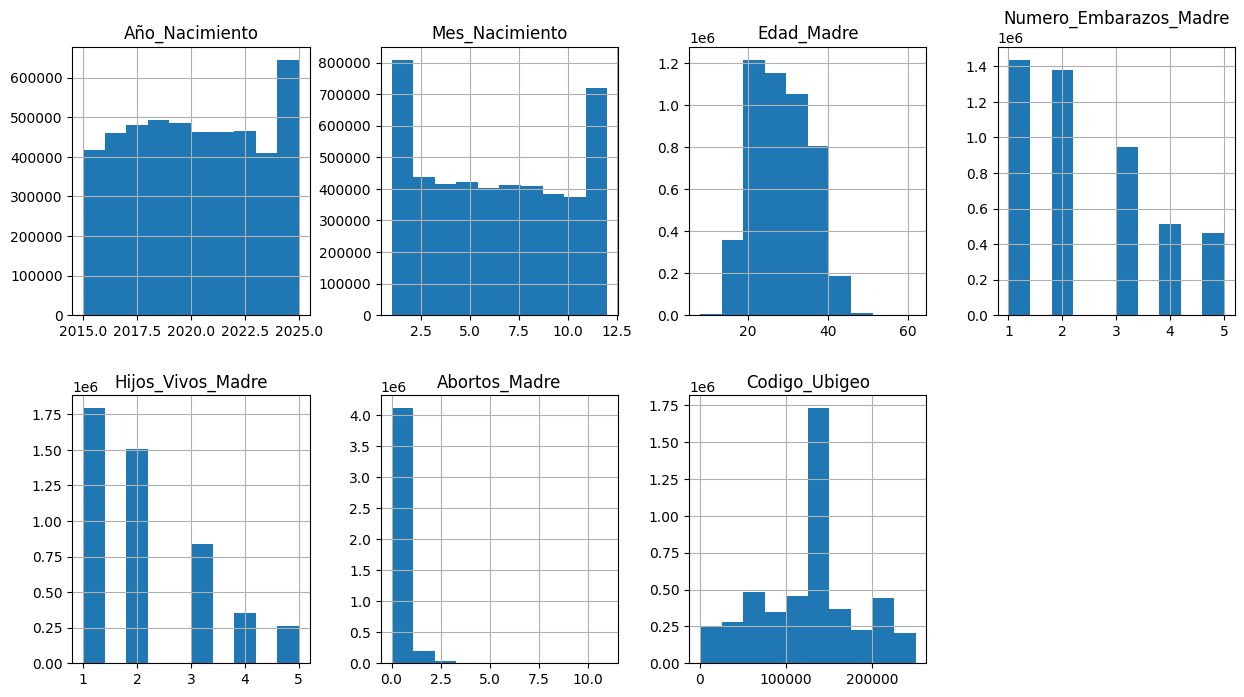

In [ ]:
# Visualizar distribuciones de variables numéricas
df_nacimientos.hist(figsize=(15,8),layout=[2,4])
plt.show()

In [ ]:
# Visualizar distribuciones de variables categóricas
cat_cols = df_nacimientos.select_dtypes(include=['object', 'category']).columns

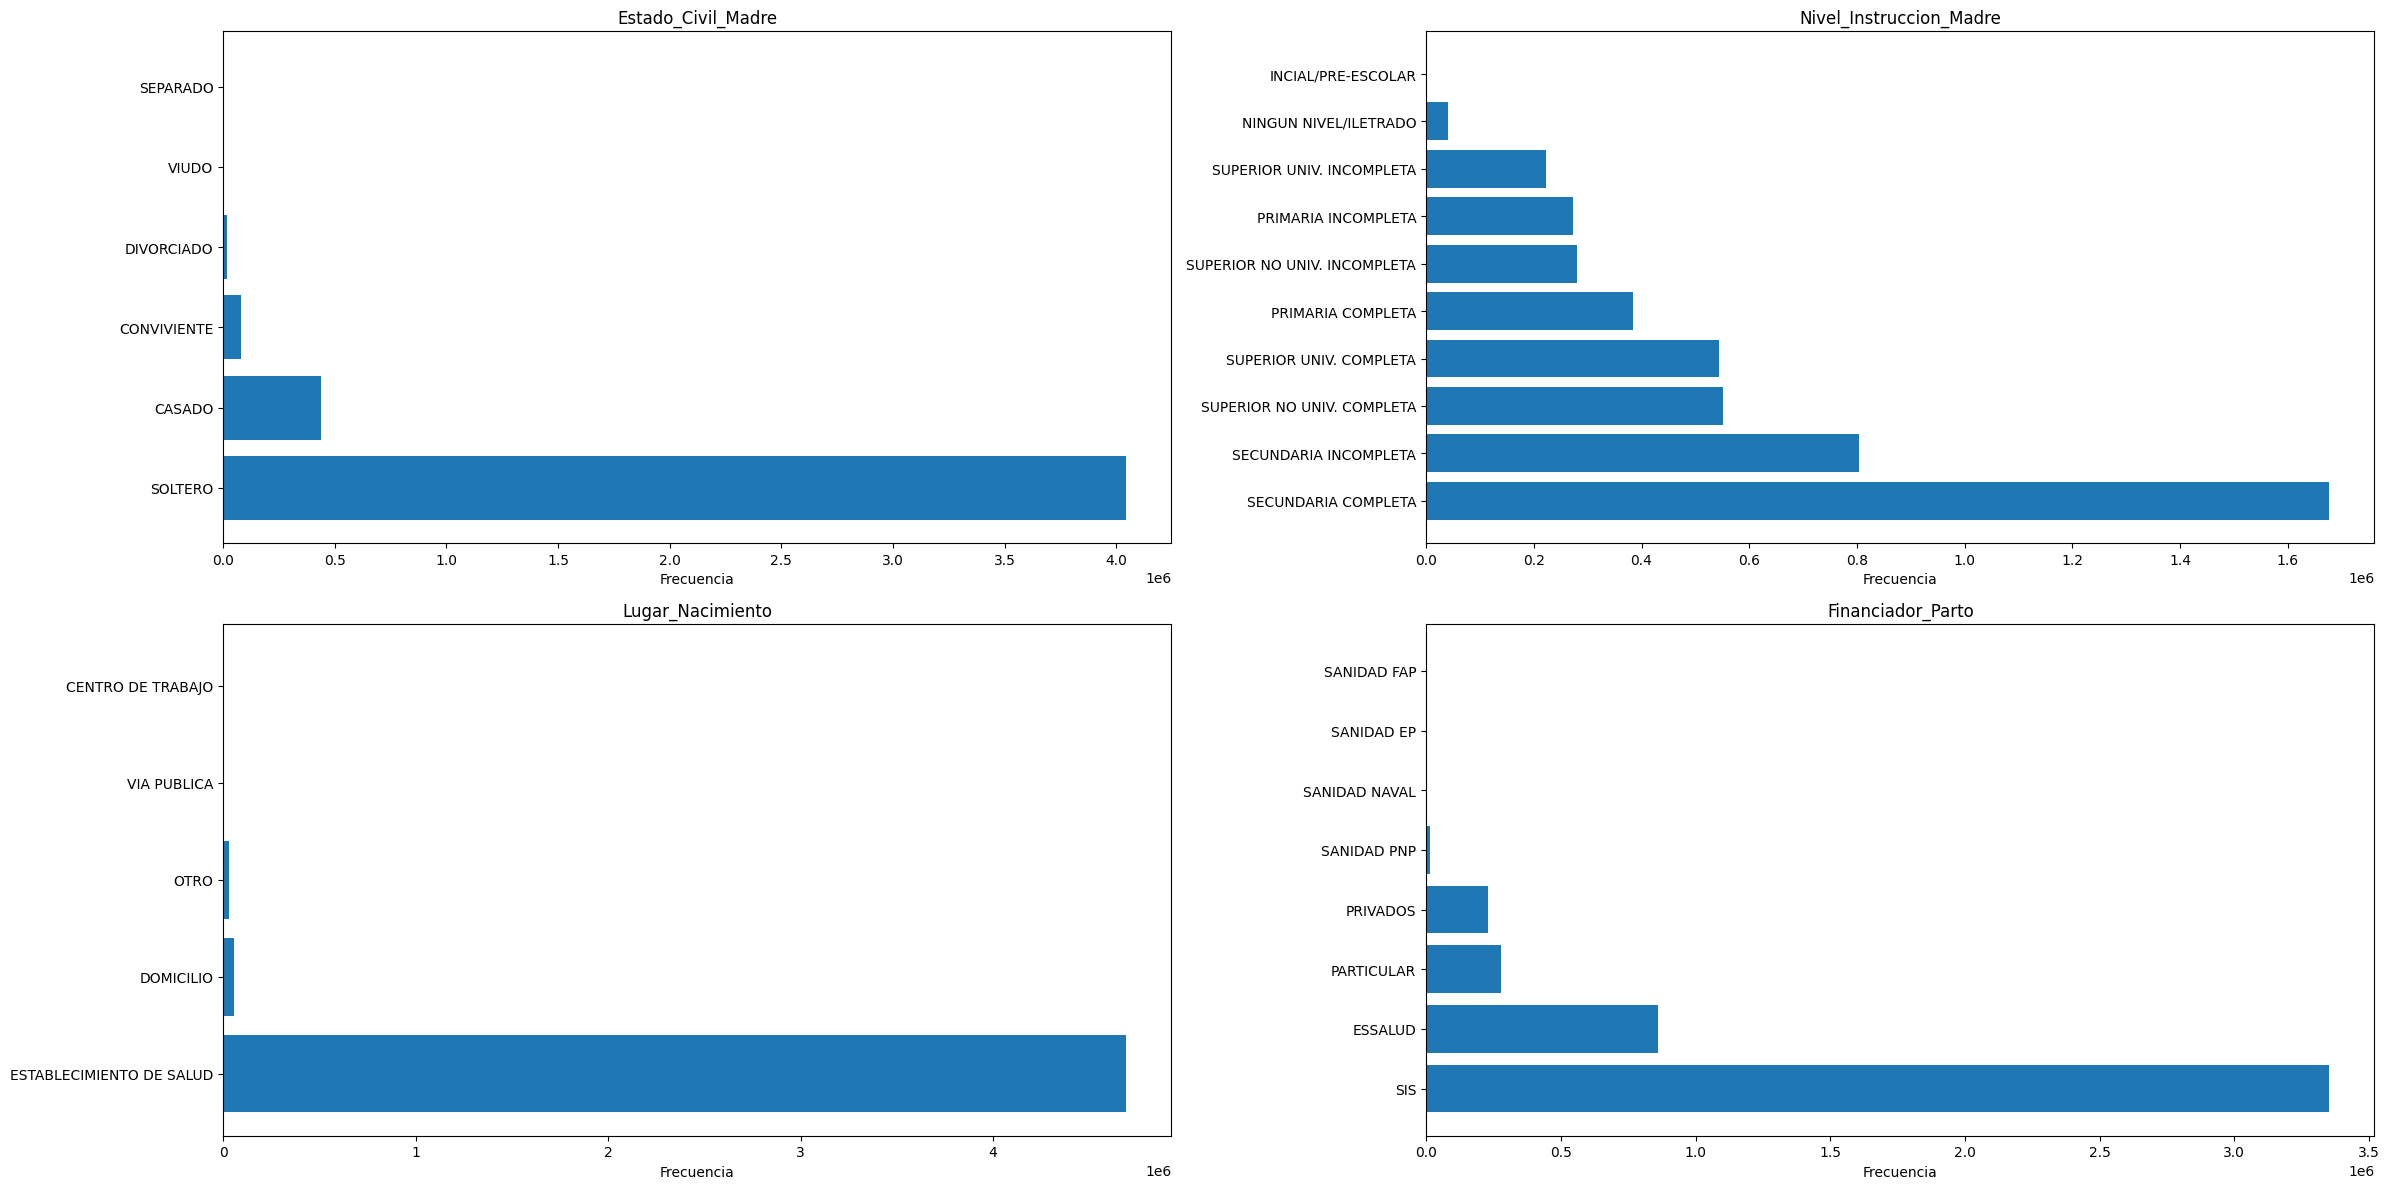

In [ ]:
# Preparar los gráficos
cols_per_row = 2
n_cols = len(cat_cols)
n_rows = math.ceil(n_cols / cols_per_row)

plt.figure(figsize=(cols_per_row * 12, n_rows * 6))

for idx, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, cols_per_row, idx)

    counts = df_nacimientos[col].value_counts()

    plt.barh(counts.index, counts.values)
    plt.title(col)
    plt.xlabel("Frecuencia")
    plt.tight_layout()

plt.show()

### **2.7. Detección de outliers y valores fuera de rango**


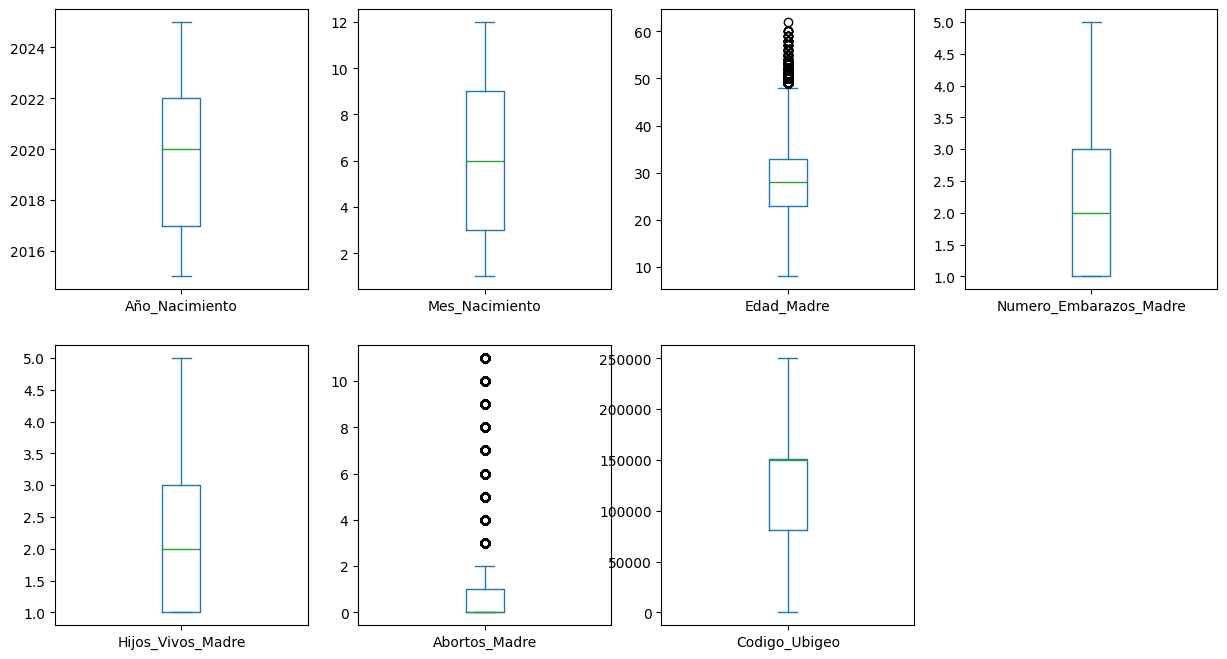

In [ ]:
# Analizar posibles valores atípicos mediante boxplots
df_nacimientos.plot(kind='box',subplots=True,sharex=True,sharey=False,layout=[2,4],figsize=(15,8))
plt.show()

**Resultado:** Analizando los boxplots, vemos que existen outliers, pero estos datos están dentro de los valores esperados según la data. Por ejemplo, para edad madre existen casos de madres cuya edad supere los 40 años. Para abortos madre, está bien mapeado los datos ya que se tienen valores de 0 a 11, y eso muestra su boxplot.

Como tenemos data importante que luego se agregará en trimestres, no haremos la imputación de nulos. Estos se ignorarán al momento de convertir las categóricas a porcentajes y las numèricas a medias

In [ ]:
df_nacimientos.head(8)

Año_Nacimiento  Mes_Nacimiento  Edad_Madre Estado_Civil_Madre  \
0            2021               1          36            SOLTERO   
1            2021               1          35            SOLTERO   
2            2021               1          32            SOLTERO   
3            2020              10          34            SOLTERO   
4            2021               1          33         DIVORCIADO   
5            2021               1          20            SOLTERO   
6            2021               1          31            SOLTERO   
7            2021               1          29            SOLTERO   

      Nivel_Instruccion_Madre  Numero_Embarazos_Madre  Hijos_Vivos_Madre  \
0         PRIMARIA INCOMPLETA                       5                  4   
1           PRIMARIA COMPLETA                       3                  3   
2         PRIMARIA INCOMPLETA                       4                  2   
3       SECUNDARIA INCOMPLETA                       4                  3   
4  SUPERIOR NO UNIV. COMPLETA                       3                  3   
5           PRIMARIA COMPLETA                       2                  2   
6         SECUNDARIA COMPLETA                       2                  1   
7       SECUNDARIA INCOMPLETA                       5                  4   

   Abortos_Madre  Codigo_Ubigeo          Lugar_Nacimiento Financiador_Parto  
0             11         200301  ESTABLECIMIENTO DE SALUD               SIS  
1              0         130102  ESTABLECIMIENTO DE SALUD               SIS  
2              2         120607  ESTABLECIMIENTO DE SALUD               SIS  
3              1         130205  ESTABLECIMIENTO DE SALUD               SIS  
4              0          70101  ESTABLECIMIENTO DE SALUD        PARTICULAR  
5              0          90206  ESTABLECIMIENTO DE SALUD               SIS  
6              1         150132  ESTABLECIMIENTO DE SALUD               SIS  
7              1         160505  ESTABLECIMIENTO DE SALUD           ESSALUD

In [ ]:
cols = df_nacimientos.columns
cols

Index(['Año_Nacimiento', 'Mes_Nacimiento', 'Edad_Madre', 'Estado_Civil_Madre',
       'Nivel_Instruccion_Madre', 'Numero_Embarazos_Madre',
       'Hijos_Vivos_Madre', 'Abortos_Madre', 'Codigo_Ubigeo',
       'Lugar_Nacimiento', 'Financiador_Parto'],
      dtype='object')

### **2.8. Agrupación de categorías**



In [ ]:
# Revisar categorías actuales antes de agrupar
cat_cols = df_nacimientos.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    print(f"\nColumna categórica: {col}")
    print(df_nacimientos[col].unique())


Columna categórica: Estado_Civil_Madre
['SOLTERO' 'DIVORCIADO' nan 'CASADO' 'CONVIVIENTE' 'VIUDO' 'SEPARADO']

Columna categórica: Nivel_Instruccion_Madre
['PRIMARIA INCOMPLETA' 'PRIMARIA COMPLETA' 'SECUNDARIA INCOMPLETA'
 'SUPERIOR NO UNIV. COMPLETA' 'SECUNDARIA COMPLETA'
 'SUPERIOR UNIV. INCOMPLETA' 'SUPERIOR UNIV. COMPLETA'
 'SUPERIOR NO UNIV. INCOMPLETA' 'NINGUN NIVEL/ILETRADO' nan
 'INCIAL/PRE-ESCOLAR']

Columna categórica: Lugar_Nacimiento
['ESTABLECIMIENTO DE SALUD' 'DOMICILIO' 'CENTRO DE TRABAJO' 'OTRO'
 'VIA PUBLICA' nan]

Columna categórica: Financiador_Parto
['SIS' 'PARTICULAR' 'ESSALUD' 'PRIVADOS' nan 'SANIDAD FAP' 'SANIDAD NAVAL'
 'SANIDAD PNP' 'SANIDAD EP']


Para el estado civil de la madre:

In [ ]:
# Agrupar estado civil en categorías más generales
map_estado_civil = {
    'CASADO': 'CON_PAREJA',
    'CONVIVIENTE': 'CON_PAREJA',
    'SOLTERO': 'SIN_PAREJA',
    'DIVORCIADO': 'SIN_PAREJA',
    'SEPARADO': 'SIN_PAREJA',
    'VIUDO': 'SIN_PAREJA'
}

df_nacimientos['Estado_Civil_Agrupado'] = df_nacimientos['Estado_Civil_Madre'].map(map_estado_civil)
# Los NaN se mantienen como NaN

Para el nivel de instrucción de la madre:

In [ ]:
# Agrupar nivel de instrucción en categorías simplificadas
map_nivel_instr = {
    # Superior
    'SUPERIOR UNIV. COMPLETA': 'SUPERIOR',
    'SUPERIOR UNIV. INCOMPLETA': 'SUPERIOR',
    'SUPERIOR NO UNIV. COMPLETA': 'SUPERIOR',
    'SUPERIOR NO UNIV. INCOMPLETA': 'SUPERIOR',

    # Secundaria
    'SECUNDARIA COMPLETA': 'SECUNDARIA',
    'SECUNDARIA INCOMPLETA': 'SECUNDARIA',

    # Primaria / baja escolaridad
    'PRIMARIA COMPLETA': 'PRIMARIA_BAJA',
    'PRIMARIA INCOMPLETA': 'PRIMARIA_BAJA',
    'NINGUN NIVEL/ILETRADO': 'PRIMARIA_BAJA',
    'INCIAL/PRE-ESCOLAR': 'PRIMARIA_BAJA'
}

df_nacimientos['Nivel_Instruccion_Agrupado'] = df_nacimientos['Nivel_Instruccion_Madre'].map(map_nivel_instr)
# De nuevo, NaN se queda como NaN

Para el lugar de nacimiento:

In [ ]:
# Normalizar y agrupar lugar de nacimiento
df_nacimientos['Lugar_Nacimiento'] = (
    df_nacimientos['Lugar_Nacimiento']
        .astype('string')
        .str.strip()
        .str.upper()
)

# Convertir la string "nan" que pudo aparecer al hacer astype('string') en NA real
df_nacimientos['Lugar_Nacimiento'] = df_nacimientos['Lugar_Nacimiento'].replace('NAN', pd.NA)

# Crear la nueva columna inicializada en NA (tipo string/categorical luego)
df_nacimientos['Lugar_Nacimiento_Agrupado'] = pd.NA

# Marcar INSTITUCIONAL
mask_inst = df_nacimientos['Lugar_Nacimiento'] == 'ESTABLECIMIENTO DE SALUD'
df_nacimientos.loc[mask_inst, 'Lugar_Nacimiento_Agrupado'] = 'INSTITUCIONAL'

# Todo lo que NO es institucional pero NO es nulo se vuelve NO_INSTITUCIONAL
mask_no_inst = df_nacimientos['Lugar_Nacimiento'].notna() & df_nacimientos['Lugar_Nacimiento_Agrupado'].isna()
df_nacimientos.loc[mask_no_inst, 'Lugar_Nacimiento_Agrupado'] = 'NO_INSTITUCIONAL'

# Pasar a categórica
df_nacimientos['Lugar_Nacimiento_Agrupado'] = df_nacimientos['Lugar_Nacimiento_Agrupado'].astype('category')

Para el financiador del parto:

In [ ]:
# Agrupar financiador del parto
map_financiador = {
    'SIS': 'SIS',
    'ESSALUD': 'ESSALUD',
    'SANIDAD FAP': 'SANIDADES',
    'SANIDAD NAVAL': 'SANIDADES',
    'SANIDAD PNP': 'SANIDADES',
    'SANIDAD EP': 'SANIDADES',
    'PARTICULAR': 'PRIVADO',
    'PRIVADOS': 'PRIVADO'
}

df_nacimientos['Financiador_Agrupado'] = df_nacimientos['Financiador_Parto'].map(map_financiador)

### **2.9. Eliminación de columnas originales**

In [ ]:
# Eliminar columnas originales que fueron reemplazadas por versiones agrupadas
cols_to_drop = [
    'Estado_Civil_Madre',
    'Nivel_Instruccion_Madre',
    'Lugar_Nacimiento',
    'Financiador_Parto'
]

df_nacimientos = df_nacimientos.drop(columns=cols_to_drop)


In [ ]:
# Vista final del dataset procesado
df_nacimientos.head()

Año_Nacimiento  Mes_Nacimiento  Edad_Madre  Numero_Embarazos_Madre  \
0            2021               1          36                       5   
1            2021               1          35                       3   
2            2021               1          32                       4   
3            2020              10          34                       4   
4            2021               1          33                       3   

   Hijos_Vivos_Madre  Abortos_Madre  Codigo_Ubigeo Estado_Civil_Agrupado  \
0                  4             11         200301            SIN_PAREJA   
1                  3              0         130102            SIN_PAREJA   
2                  2              2         120607            SIN_PAREJA   
3                  3              1         130205            SIN_PAREJA   
4                  3              0          70101            SIN_PAREJA   

  Nivel_Instruccion_Agrupado Lugar_Nacimiento_Agrupado Financiador_Agrupado  
0              PRIMARIA_BAJA             INSTITUCIONAL                  SIS  
1              PRIMARIA_BAJA             INSTITUCIONAL                  SIS  
2              PRIMARIA_BAJA             INSTITUCIONAL                  SIS  
3                 SECUNDARIA             INSTITUCIONAL                  SIS  
4                   SUPERIOR             INSTITUCIONAL              PRIVADO

## **3. Preparación final del Dataset**

### **3.1. Integración con datos geográficos (Ubigeos)**

In [ ]:
# =============================================================================
# Fuente: Geodir / INEI
# Dataset: Catálogo de Ubigeo del INEI (2019)
# Enlace: https://account.geodir.co/recursos/ubigeo-inei-peru.html
# =============================================================================

# Cargar dataset de ubigeos para obtener departamentos
df_ubigeos = pd.read_csv("Lista_Ubigeos_INEI.csv", delimiter=';')
df_ubigeos.head()

UBIGEO_INEI DEPARTAMENTO    PROVINCIA     DISTRITO
0        10101     AMAZONAS  CHACHAPOYAS  CHACHAPOYAS
1        10102     AMAZONAS  CHACHAPOYAS     ASUNCION
2        10103     AMAZONAS  CHACHAPOYAS       BALSAS
3        10104     AMAZONAS  CHACHAPOYAS        CHETO
4        10105     AMAZONAS  CHACHAPOYAS    CHILIQUIN

In [ ]:
# Realizar merge para enriquecer los datos con los departamentos respectivos
df_nacimientos = df_nacimientos.merge(
    df_ubigeos[["UBIGEO_INEI", "DEPARTAMENTO"]],
    left_on="Codigo_Ubigeo",
    right_on="UBIGEO_INEI",
    how="left"
)

# Renombrar la nueva columna
df_nacimientos = df_nacimientos.rename(columns={"DEPARTAMENTO": "Departamento"})


In [ ]:
# Eliminar columnas redundantes después del merge (Codigo_Ubigeo y UBIGEO_INEI)
df_nacimientos = df_nacimientos.drop(columns=["Codigo_Ubigeo", "UBIGEO_INEI"])
df_nacimientos.head(5)

Año_Nacimiento  Mes_Nacimiento  Edad_Madre  Numero_Embarazos_Madre  \
0            2021               1          36                       5   
1            2021               1          35                       3   
2            2021               1          32                       4   
3            2020              10          34                       4   
4            2021               1          33                       3   

   Hijos_Vivos_Madre  Abortos_Madre Estado_Civil_Agrupado  \
0                  4             11            SIN_PAREJA   
1                  3              0            SIN_PAREJA   
2                  2              2            SIN_PAREJA   
3                  3              1            SIN_PAREJA   
4                  3              0            SIN_PAREJA   

  Nivel_Instruccion_Agrupado Lugar_Nacimiento_Agrupado Financiador_Agrupado  \
0              PRIMARIA_BAJA             INSTITUCIONAL                  SIS   
1              PRIMARIA_BAJA             INSTITUCIONAL                  SIS   
2              PRIMARIA_BAJA             INSTITUCIONAL                  SIS   
3                 SECUNDARIA             INSTITUCIONAL                  SIS   
4                   SUPERIOR             INSTITUCIONAL              PRIVADO   

  Departamento  
0        PIURA  
1  LA LIBERTAD  
2        JUNIN  
3  LA LIBERTAD  
4       CALLAO

### **3.2. Transformación de variables temporales**

Formamos columna de trimestre, renombramos y ordenamos.

In [ ]:
# Crear columna de trimestre a partir del mes de nacimiento
df_nacimientos['Trimestre'] = ((df_nacimientos['Mes_Nacimiento'] - 1) // 3 + 1).astype('Int64')

# Renombrar columna de año
df_nacimientos = df_nacimientos.rename(columns={'Año_Nacimiento': 'Anho'})

# Eliminar columna de mes ya que ahora tenemos trimestre
df_nacimientos = df_nacimientos.drop(columns=['Mes_Nacimiento'])

In [ ]:
# Verificar porcentaje de valores nulos en el dataset después de las transformaciones
print("Porcentaje de valores nulos encontrados en total: \n", 100*df_nacimientos.isnull().sum() /df_nacimientos.shape[0])

# Eliminar registros sin departamento asignado
df_nacimientos = df_nacimientos.dropna(subset=['Departamento'])

Porcentaje de valores nulos encontrados en total: 
 Anho                          0.000000
Edad_Madre                    0.000000
Numero_Embarazos_Madre        1.024848
Hijos_Vivos_Madre             0.767517
Abortos_Madre                 8.601101
Estado_Civil_Agrupado         4.159503
Nivel_Instruccion_Agrupado    0.054549
Lugar_Nacimiento_Agrupado     0.005062
Financiador_Agrupado          0.788140
Departamento                  0.242125
Trimestre                     0.000000
dtype: float64


In [ ]:
print("Porcentaje de valores nulos luego del dropeo: \n", 100*df_nacimientos.isnull().sum() /df_nacimientos.shape[0])

Porcentaje de valores nulos luego del dropeo: 
 Anho                          0.000000
Edad_Madre                    0.000000
Numero_Embarazos_Madre        1.023645
Hijos_Vivos_Madre             0.766822
Abortos_Madre                 8.603841
Estado_Civil_Agrupado         4.164231
Nivel_Instruccion_Agrupado    0.054472
Lugar_Nacimiento_Agrupado     0.005053
Financiador_Agrupado          0.786803
Departamento                  0.000000
Trimestre                     0.000000
dtype: float64


### **3.3. Reorganización del dataset**

In [ ]:
# Definir columnas base
cols_base = ['Anho', 'Trimestre', 'Departamento']

# Obtener todas las demás columnas
cols_rest = [c for c in df_nacimientos.columns if c not in cols_base]

# Reordenar DataFrame
df_nacimientos = df_nacimientos[cols_base + cols_rest]


In [ ]:
df_nacimientos.head(7)

Anho  Trimestre  Departamento  Edad_Madre  Numero_Embarazos_Madre  \
0  2021          1         PIURA          36                       5   
1  2021          1   LA LIBERTAD          35                       3   
2  2021          1         JUNIN          32                       4   
3  2020          4   LA LIBERTAD          34                       4   
4  2021          1        CALLAO          33                       3   
5  2021          1  HUANCAVELICA          20                       2   
6  2021          1          LIMA          31                       2   

   Hijos_Vivos_Madre  Abortos_Madre Estado_Civil_Agrupado  \
0                  4             11            SIN_PAREJA   
1                  3              0            SIN_PAREJA   
2                  2              2            SIN_PAREJA   
3                  3              1            SIN_PAREJA   
4                  3              0            SIN_PAREJA   
5                  2              0            SIN_PAREJA   
6                  1              1            SIN_PAREJA   

  Nivel_Instruccion_Agrupado Lugar_Nacimiento_Agrupado Financiador_Agrupado  
0              PRIMARIA_BAJA             INSTITUCIONAL                  SIS  
1              PRIMARIA_BAJA             INSTITUCIONAL                  SIS  
2              PRIMARIA_BAJA             INSTITUCIONAL                  SIS  
3                 SECUNDARIA             INSTITUCIONAL                  SIS  
4                   SUPERIOR             INSTITUCIONAL              PRIVADO  
5              PRIMARIA_BAJA             INSTITUCIONAL                  SIS  
6                 SECUNDARIA             INSTITUCIONAL                  SIS

In [ ]:
# Verificar columnas finales
cols_df = df_nacimientos.columns
cols_df

Index(['Anho', 'Trimestre', 'Departamento', 'Edad_Madre',
       'Numero_Embarazos_Madre', 'Hijos_Vivos_Madre', 'Abortos_Madre',
       'Estado_Civil_Agrupado', 'Nivel_Instruccion_Agrupado',
       'Lugar_Nacimiento_Agrupado', 'Financiador_Agrupado'],
      dtype='object')

## **4. Agregación y Construcción del Dataset para modelado**

### **4.1. Agregación por año y trimestre**

In [ ]:
# Definir columnas para agrupar
group_cols = ['Departamento', 'Anho', 'Trimestre']
g = df_nacimientos.groupby(group_cols)

In [ ]:
# Crear dataset base con conteo de nacimientos
df_panel = (
    g.size()
     .rename('Nacimientos')
     .reset_index()
)

### **4.2. Cálculo de variables de la edad materna**

In [ ]:
# Calcular estadísticas agregadas de la edad de la madre
edad_agg = g['Edad_Madre'].agg(
    Edad_Media = 'mean',
    Pct_Adolescentes = lambda s: ( (s < 20).sum() / s.notna().sum() ) if s.notna().sum() > 0 else np.nan,
    Pct_Mayores35   = lambda s: ( (s >= 35).sum() / s.notna().sum() ) if s.notna().sum() > 0 else np.nan
)

edad_agg = edad_agg.reset_index()
df_panel = df_panel.merge(edad_agg, on=group_cols, how='left')

### **4.3. Cálculo de variables de la historia reproductiva**

In [ ]:
# Calcular promedios de las variables reproductivas
repro_agg = g[['Numero_Embarazos_Madre', 'Hijos_Vivos_Madre', 'Abortos_Madre']].agg('mean')
repro_agg = repro_agg.rename(columns={
    'Numero_Embarazos_Madre': 'Embarazos_Prom',
    'Hijos_Vivos_Madre': 'HijosVivos_Prom',
    'Abortos_Madre': 'Abortos_Prom'
}).reset_index()

df_panel = df_panel.merge(repro_agg, on=group_cols, how='left')

### **4.4. Cálculo de proporciones categóricas**

In [ ]:
# Función para calcular proporciones departamentales
def calcular_proporciones_departamentales(g, group_cols, columna_agrupada, prefix):
    prop_departamental = (
        g[columna_agrupada]
        .value_counts(normalize=True)
        .rename('valor')
        .rename_axis(index=group_cols + [columna_agrupada])
        .reset_index()
        .pivot(index=group_cols,
               columns=columna_agrupada,
               values='valor')
        .add_prefix(prefix)
        .reset_index()
    )
    return prop_departamental

In [ ]:
# Calcular todas las proporciones departamentales
estado_prop = calcular_proporciones_departamentales(g, group_cols, 'Estado_Civil_Agrupado', 'Pct_EstadoCivil_')
nivel_prop = calcular_proporciones_departamentales(g, group_cols, 'Nivel_Instruccion_Agrupado', 'Pct_Nivel_')
lugar_prop = calcular_proporciones_departamentales(g, group_cols, 'Lugar_Nacimiento_Agrupado', 'Pct_Lugar_')
finan_prop = calcular_proporciones_departamentales(g, group_cols, 'Financiador_Agrupado', 'Pct_Financ_')

# Unir todas las proporciones al dataset panel
df_panel = df_panel.merge(estado_prop, on=group_cols, how='left')
df_panel = df_panel.merge(nivel_prop, on=group_cols, how='left')
df_panel = df_panel.merge(lugar_prop, on=group_cols, how='left')
df_panel = df_panel.merge(finan_prop, on=group_cols, how='left')

### **4.5. Imputación de valores en proporciones**

In [ ]:
# Identificar columnas proporcionales (empiezan con Pct_)
pct_cols = [c for c in df_panel.columns if c.startswith('Pct_')]

# Imputar 0 solo en columnas proporcionales
df_panel[pct_cols] = df_panel[pct_cols].fillna(0)

In [ ]:
df_panel.head()

Departamento  Anho  Trimestre  Nacimientos  Edad_Media  Pct_Adolescentes  \
0     AMAZONAS  2015          1         1138   27.203866          0.144112   
1     AMAZONAS  2015          2         1224   26.524510          0.194444   
2     AMAZONAS  2015          3         1302   26.683564          0.176651   
3     AMAZONAS  2015          4         1277   26.439311          0.198904   
4     AMAZONAS  2016          1         1375   26.895273          0.172364   

   Pct_Mayores35  Embarazos_Prom  HijosVivos_Prom  Abortos_Prom  ...  \
0       0.194200        2.417108         2.198763      0.299235  ...   
1       0.163399        2.389718         2.144509      0.290559  ...   
2       0.172811        2.426357         2.223338      0.265546  ...   
3       0.158966        2.460568         2.210526      0.275501  ...   
4       0.179636        2.382138         2.187865      0.239934  ...   

   Pct_EstadoCivil_SIN_PAREJA  Pct_Nivel_PRIMARIA_BAJA  Pct_Nivel_SECUNDARIA  \
0                    0.957184                 0.333040              0.463972   
1                    0.948556                 0.308007              0.495098   
2                    0.954583                 0.320276              0.459293   
3                    0.961832                 0.348473              0.441660   
4                    0.949247                 0.322182              0.457455   

   Pct_Nivel_SUPERIOR  Pct_Lugar_INSTITUCIONAL  Pct_Lugar_NO_INSTITUCIONAL  \
0            0.202988                 0.988576                    0.011424   
1            0.196895                 0.991013                    0.008987   
2            0.220430                 0.989247                    0.010753   
3            0.209867                 0.988254                    0.011746   
4            0.220364                 0.989091                    0.010909   

   Pct_Financ_ESSALUD  Pct_Financ_PRIVADO  Pct_Financ_SANIDADES  \
0            0.139576            0.030035              0.000000   
1            0.131859            0.014742              0.004914   
2            0.143408            0.019275              0.000771   
3            0.119122            0.015674              0.001567   
4            0.130752            0.015340              0.002922   

   Pct_Financ_SIS  
0        0.830389  
1        0.848485  
2        0.836546  
3        0.863636  
4        0.850986  

[5 rows x 21 columns]

## **5. Integración con la población y Cálculo de la tasa**

### **5.1. Carga y preparación de datos de población**

In [ ]:
# =============================================================================
# Fuente: Instituto Nacional de Estadística e Informática (INEI)
# Dataset: Proyecciones de Población por Departamento
# Enlace: https://m.inei.gob.pe/estadisticas/indice-tematico/population-estimates-and-projections/
# =============================================================================

# Cargar dataset de poblaciones trimestrales
df_poblacion = pd.read_csv('poblaciones_trimestrales_con_tasas.csv')
# Cargar dataset de poblaciones trimestrales
df_poblacion = pd.read_csv('poblaciones_trimestrales_con_tasas.csv')

# Convertir trimestre de formato "T1" a uno numérico
df_poblacion['Trimestre'] = df_poblacion['Trimestre'].str.replace('T', '').astype(int)

In [ ]:
# Renombrar columna
df_poblacion = df_poblacion.rename(columns={'Año': 'Anho'})

In [ ]:
# Función para normalizar nombres de departamentos
def normalizar_departamento(nombre):
    nombre = nombre.upper().strip()
    # Eliminar tildes y caracteres especiales
    reemplazos = {
        'Á': 'A', 'É': 'E', 'Í': 'I', 'Ó': 'O', 'Ú': 'U',
        'Ü': 'U', 'Ñ': 'N'
    }
    for viejo, nuevo in reemplazos.items():
        nombre = nombre.replace(viejo, nuevo)

    # Caso especial para Callao
    if 'CALLAO' in nombre:
        return 'CALLAO'

    return nombre

# Aplicar normalización
df_poblacion['Departamento'] = df_poblacion['Departamento'].apply(normalizar_departamento)

### **5.2. Unión con datos de población**

In [ ]:
# Realizar merge con los datos de población
df_panel = df_panel.merge(
    df_poblacion[['Anho', 'Trimestre', 'Departamento', 'Poblacion_Trimestral']],
    on=['Departamento', 'Anho', 'Trimestre'],
    how='left'
)

In [ ]:
df_panel.head()

Departamento  Anho  Trimestre  Nacimientos  Edad_Media  Pct_Adolescentes  \
0     AMAZONAS  2015          1         1138   27.203866          0.144112   
1     AMAZONAS  2015          2         1224   26.524510          0.194444   
2     AMAZONAS  2015          3         1302   26.683564          0.176651   
3     AMAZONAS  2015          4         1277   26.439311          0.198904   
4     AMAZONAS  2016          1         1375   26.895273          0.172364   

   Pct_Mayores35  Embarazos_Prom  HijosVivos_Prom  Abortos_Prom  ...  \
0       0.194200        2.417108         2.198763      0.299235  ...   
1       0.163399        2.389718         2.144509      0.290559  ...   
2       0.172811        2.426357         2.223338      0.265546  ...   
3       0.158966        2.460568         2.210526      0.275501  ...   
4       0.179636        2.382138         2.187865      0.239934  ...   

   Pct_Nivel_PRIMARIA_BAJA  Pct_Nivel_SECUNDARIA  Pct_Nivel_SUPERIOR  \
0                 0.333040              0.463972            0.202988   
1                 0.308007              0.495098            0.196895   
2                 0.320276              0.459293            0.220430   
3                 0.348473              0.441660            0.209867   
4                 0.322182              0.457455            0.220364   

   Pct_Lugar_INSTITUCIONAL  Pct_Lugar_NO_INSTITUCIONAL  Pct_Financ_ESSALUD  \
0                 0.988576                    0.011424            0.139576   
1                 0.991013                    0.008987            0.131859   
2                 0.989247                    0.010753            0.143408   
3                 0.988254                    0.011746            0.119122   
4                 0.989091                    0.010909            0.130752   

   Pct_Financ_PRIVADO  Pct_Financ_SANIDADES  Pct_Financ_SIS  \
0            0.030035              0.000000        0.830389   
1            0.014742              0.004914        0.848485   
2            0.019275              0.000771        0.836546   
3            0.015674              0.001567        0.863636   
4            0.015340              0.002922        0.850986   

   Poblacion_Trimestral  
0                408751  
1                409444  
2                410138  
3                410832  
4                411525  

[5 rows x 22 columns]

### **5.3. Cálculo de la tasa de natalidad**

In [ ]:
# Calcular tasa de natalidad trimestral con población total
df_panel['Tasa_Natalidad_Trimestral'] = (
    df_panel['Nacimientos'] / df_panel['Poblacion_Trimestral']
)
# Por 1000 habitantes
df_panel['Tasa_Natalidad_Trimestral'] *= 1000

In [ ]:
df_panel.head()

Departamento  Anho  Trimestre  Nacimientos  Edad_Media  Pct_Adolescentes  \
0     AMAZONAS  2015          1         1138   27.203866          0.144112   
1     AMAZONAS  2015          2         1224   26.524510          0.194444   
2     AMAZONAS  2015          3         1302   26.683564          0.176651   
3     AMAZONAS  2015          4         1277   26.439311          0.198904   
4     AMAZONAS  2016          1         1375   26.895273          0.172364   

   Pct_Mayores35  Embarazos_Prom  HijosVivos_Prom  Abortos_Prom  ...  \
0       0.194200        2.417108         2.198763      0.299235  ...   
1       0.163399        2.389718         2.144509      0.290559  ...   
2       0.172811        2.426357         2.223338      0.265546  ...   
3       0.158966        2.460568         2.210526      0.275501  ...   
4       0.179636        2.382138         2.187865      0.239934  ...   

   Pct_Nivel_SECUNDARIA  Pct_Nivel_SUPERIOR  Pct_Lugar_INSTITUCIONAL  \
0              0.463972            0.202988                 0.988576   
1              0.495098            0.196895                 0.991013   
2              0.459293            0.220430                 0.989247   
3              0.441660            0.209867                 0.988254   
4              0.457455            0.220364                 0.989091   

   Pct_Lugar_NO_INSTITUCIONAL  Pct_Financ_ESSALUD  Pct_Financ_PRIVADO  \
0                    0.011424            0.139576            0.030035   
1                    0.008987            0.131859            0.014742   
2                    0.010753            0.143408            0.019275   
3                    0.011746            0.119122            0.015674   
4                    0.010909            0.130752            0.015340   

   Pct_Financ_SANIDADES  Pct_Financ_SIS  Poblacion_Trimestral  \
0              0.000000        0.830389                408751   
1              0.004914        0.848485                409444   
2              0.000771        0.836546                410138   
3              0.001567        0.863636                410832   
4              0.002922        0.850986                411525   

   Tasa_Natalidad_Trimestral  
0                   2.784091  
1                   2.989420  
2                   3.174541  
3                   3.108327  
4                   3.341231  

[5 rows x 23 columns]

### **5.4. Verificación de dimensiones finales**

In [ ]:
print(f"Dataset departamental: {df_panel.shape}")
print("Valores nulos en tasa departamental:", df_panel['Tasa_Natalidad_Trimestral'].isnull().sum())

Dataset departamental: (1075, 23)
Valores nulos en tasa departamental: 0


## **6. Análisis exploratorio del Dataset final**



### **6.1. Análisis de distribución de variables**

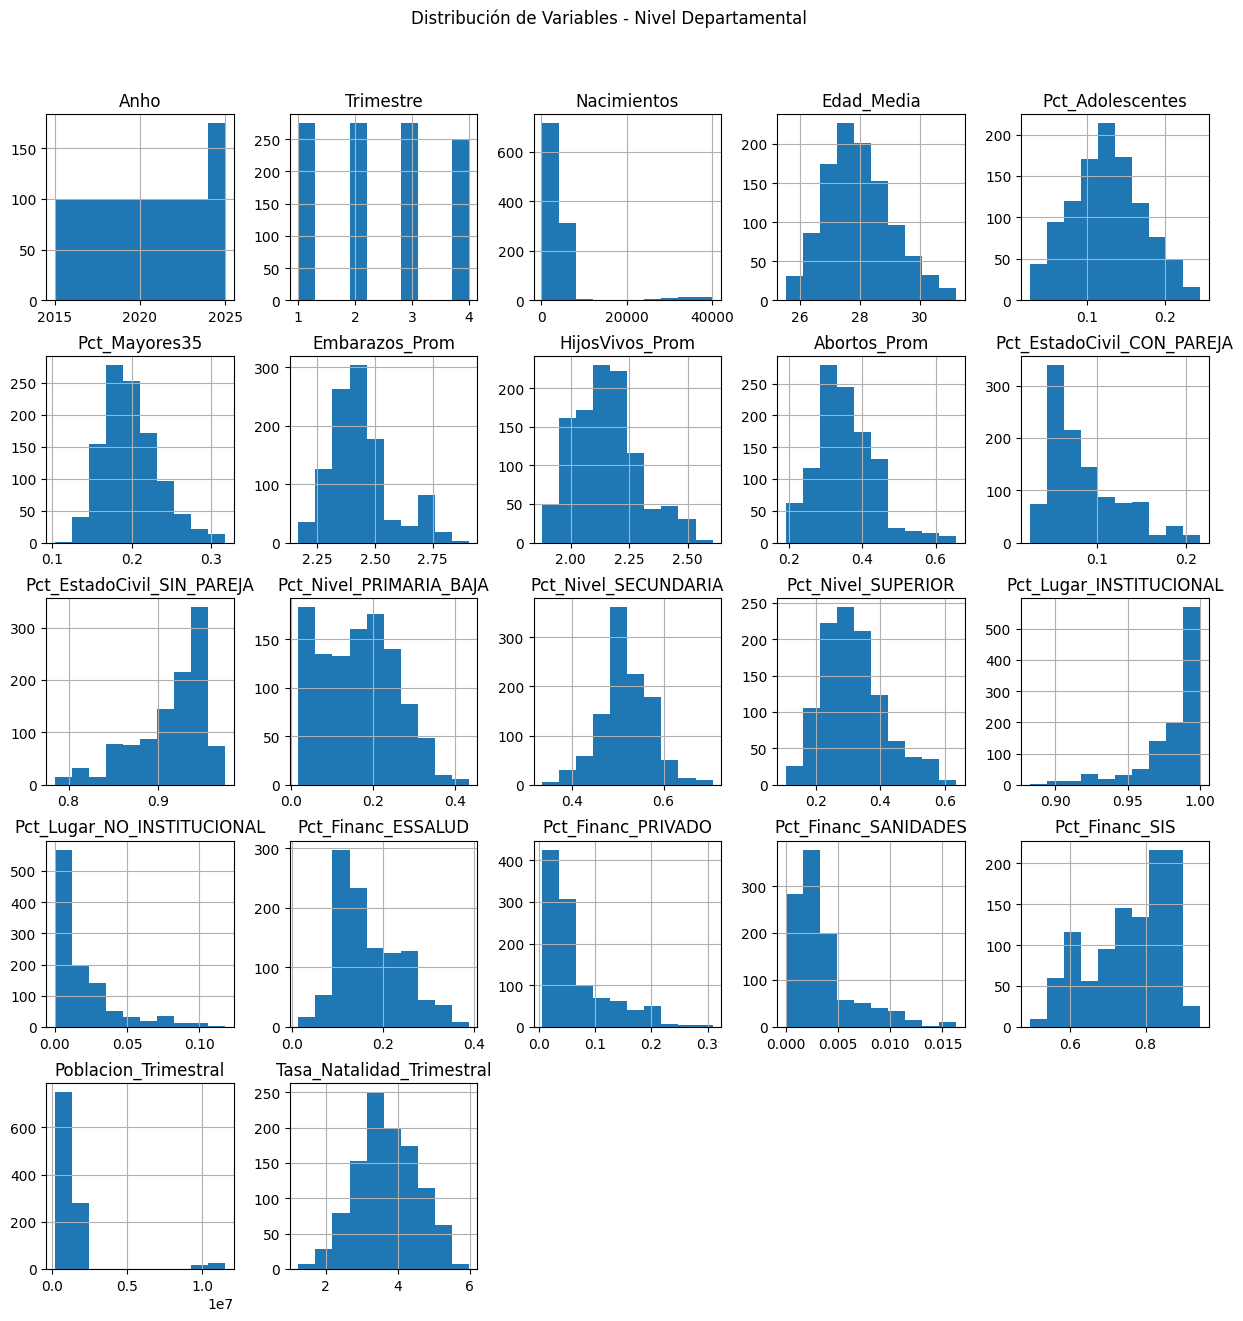

In [ ]:
# Visualizar distribuciones de todas las variables numéricas
df_panel.hist(figsize=(15,15),layout=(5,5))
plt.suptitle('Distribución de Variables - Nivel Departamental', y=0.95)
plt.show()


### **6.2. Análisis de correlaciones entre variables**

Graficamos las matrices de correlación.

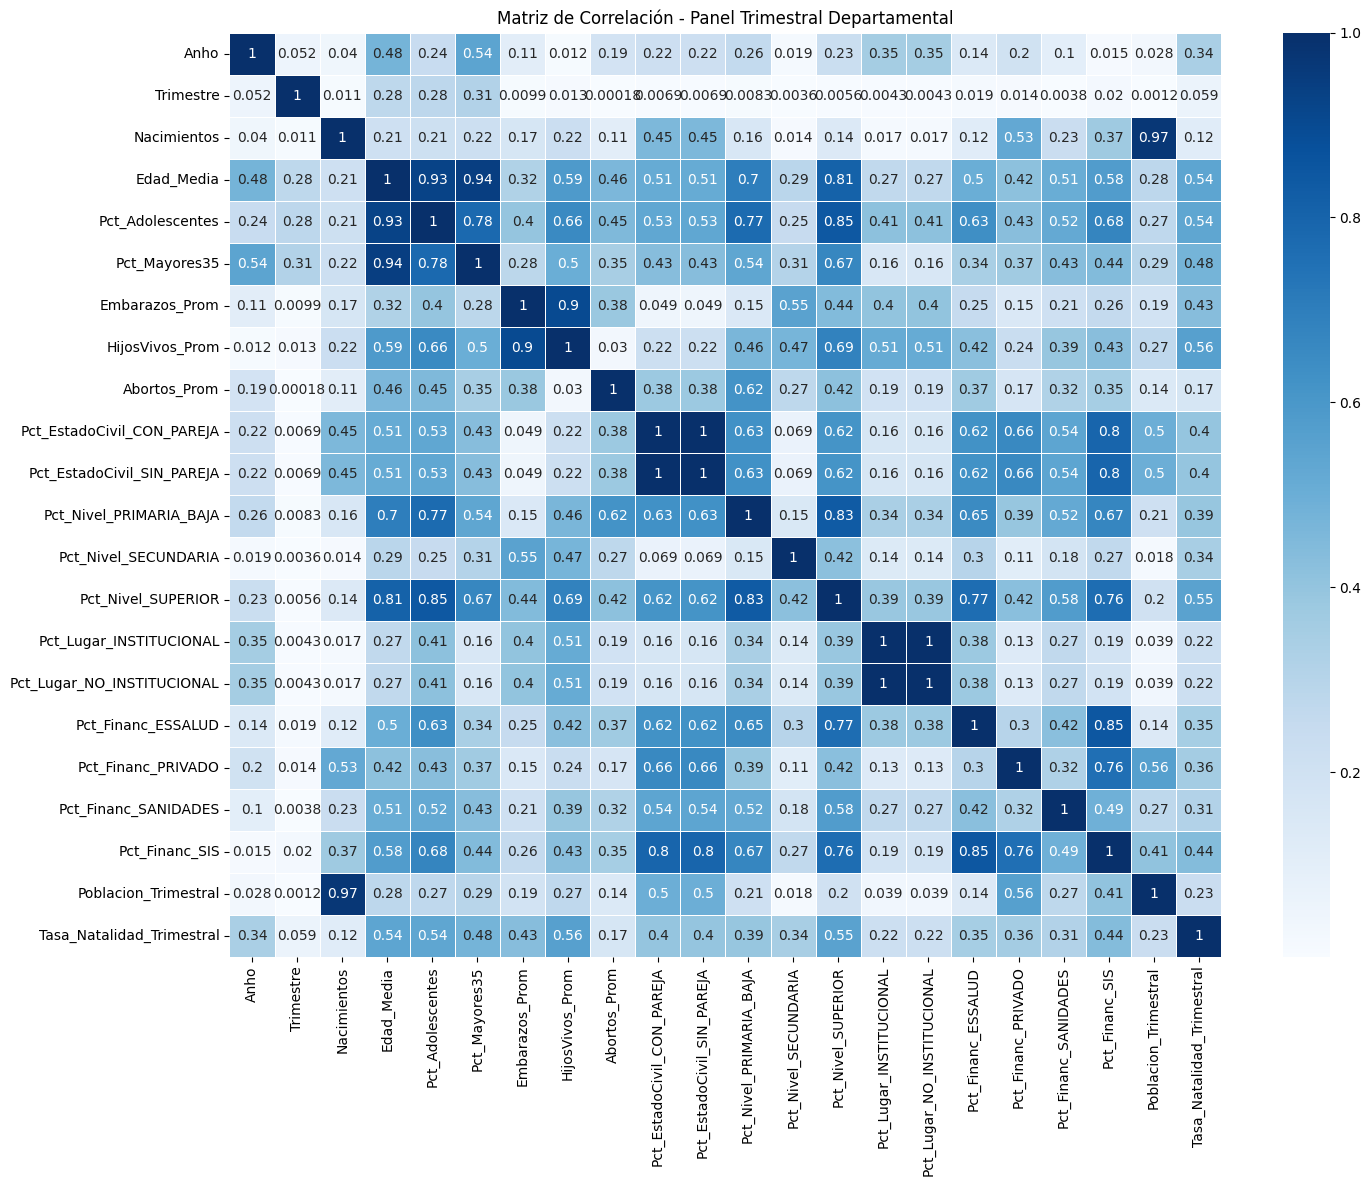

In [ ]:
# Seleccionar solo variables numéricas
df_corr = df_panel.select_dtypes(include=[np.number])

# Calcular matriz de correlación absoluta
corr = df_corr.corr().abs() # es más útil para identificar relaciones fuertes

# Visualizar matriz de correlación
plt.figure(figsize=(16, 12))
sns.heatmap(
    corr,
    annot=True,
    cmap='Blues',
    linewidths=0.5
)
plt.title('Matriz de Correlación - Panel Trimestral Departamental')
plt.show()


**Resultado:** Identificamos variables con alta correlación (mayor o igual a 0.9), como Nacimiento y Poblacion_Trimestral (0.97).

### **6.3. Identificación y manejo de variables altamente correlacionadas**



In [ ]:
# Definir umbral para considerar correlación alta
umbral = 0.9

In [ ]:
# Extraer pares de variables correlacionadas
# Solo el triángulo superior para evitar duplicados
corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .reset_index()
)

corr_pairs.columns = ['Variable_1', 'Variable_2', 'Correlacion']

# Filtrar pares con correlación por encima del umbral
corr_altas = corr_pairs[corr_pairs['Correlacion'] >= umbral]\
             .sort_values(by='Correlacion', ascending=False)

corr_altas

Variable_1                  Variable_2  Correlacion
203     Pct_Lugar_INSTITUCIONAL  Pct_Lugar_NO_INSTITUCIONAL     1.000000
153  Pct_EstadoCivil_CON_PAREJA  Pct_EstadoCivil_SIN_PAREJA     1.000000
58                  Nacimientos        Poblacion_Trimestral     0.972065
61                   Edad_Media               Pct_Mayores35     0.941798
60                   Edad_Media            Pct_Adolescentes     0.925979

In [ ]:
# Eliminar variables redundantes identificadas en el análisis de correlación
df_final = df_panel.drop(columns=['Pct_Lugar_NO_INSTITUCIONAL', 'Pct_EstadoCivil_SIN_PAREJA', 'Nacimientos'])

df_final.shape

(1075, 20)

Se eliminaron *Pct_Lugar_NO_INSTITUCIONAL*, *Pct_EstadoCivil_SIN_PAREJA* y *Nacimientos* por presentar correlaciones perfectas (1.0) o muy altas (0.97) que indican redundancia informativa y riesgo de multicolinealidad en los modelos predictivos.

### **6.4. Exportación del dataset final**

In [ ]:
# Guardar y descargar el dataset final procesado
from google.colab import files

# Exportar dataset departamental
df_final.to_csv('dataset_final_natalidad.csv', index=False)
files.download('dataset_final_natalidad.csv')

print("Dataset exportado:")
print(" - dataset_final_natalidad.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dataset exportado:
 - dataset_final_natalidad.csv


In [ ]:
# Verificar dimensión final

print(f"Dataset departamental: {df_final.shape}")

Dataset departamental: (1075, 20)


### **6.5. Matriz de correlación del dataset final**

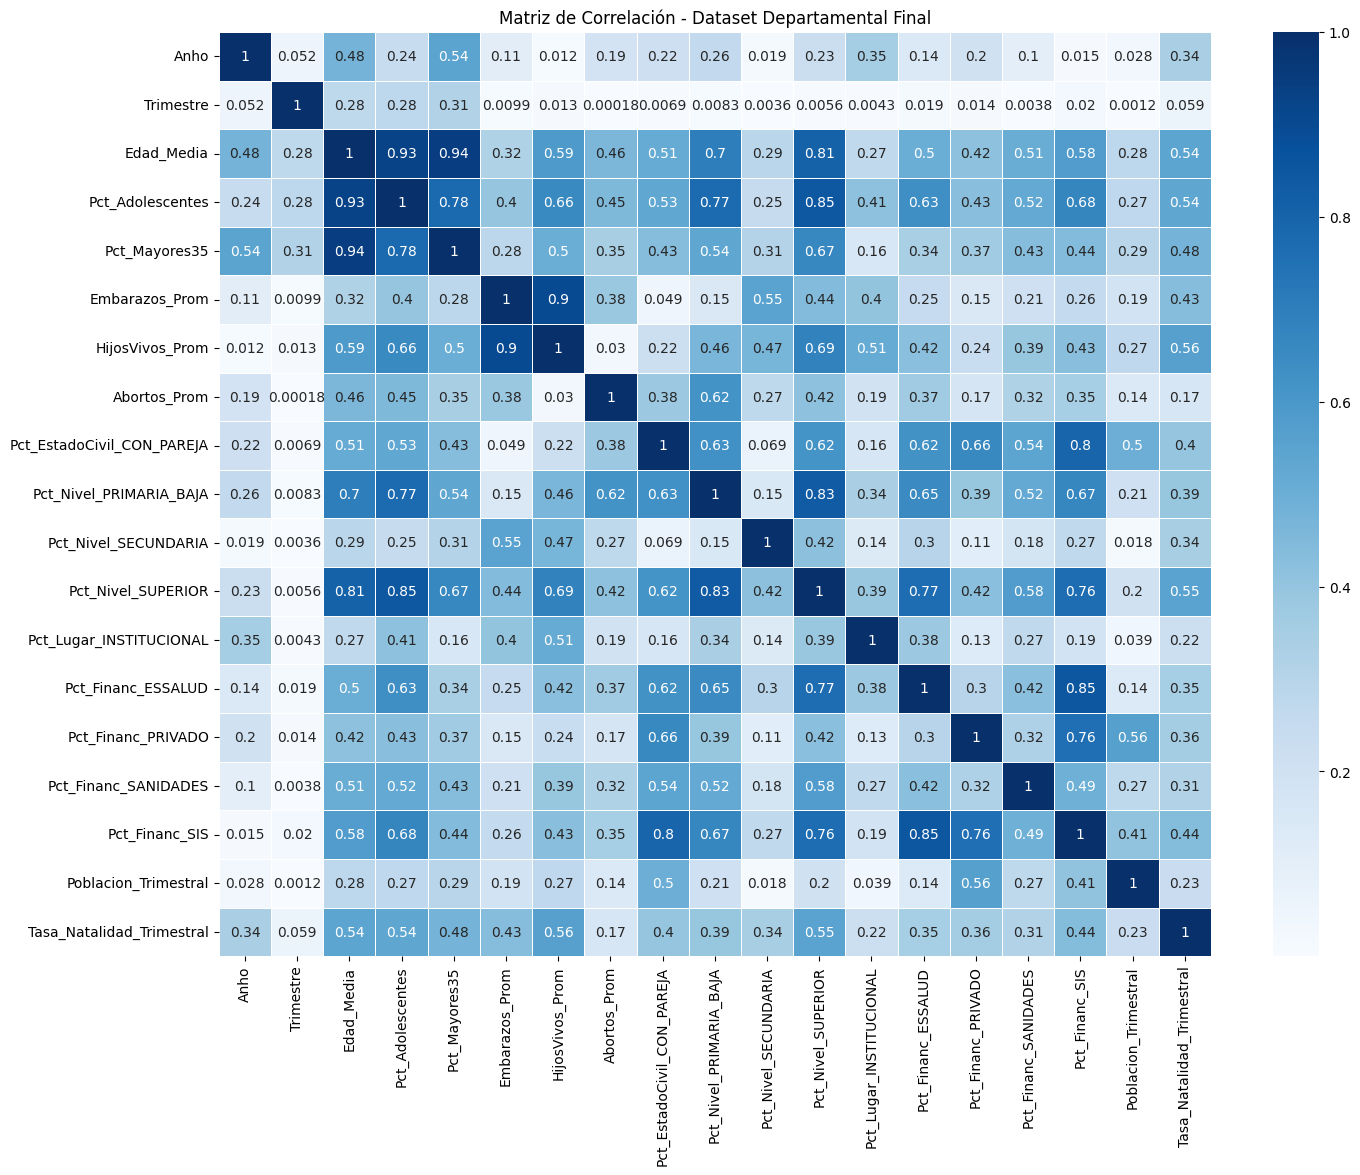

In [ ]:
# Recalcular matriz de correlación después de eliminar variables redundantes
df_corr2 = df_final.select_dtypes(include=[np.number])
corr = df_corr2.corr().abs()

# Visualizar nueva matriz de correlación
plt.figure(figsize=(16, 12))
sns.heatmap(
    corr,
    annot=True,
    cmap='Blues',
    linewidths=0.5
)
plt.title('Matriz de Correlación - Dataset Departamental Final')
plt.show()


### **6.6. Análisis de comportamiento temporal de la tasa de natalidad**

In [ ]:
# Mapeo de trimestres a meses (primer mes de cada trimestre)
mes_trimestre = {1:1, 2:4, 3:7, 4:10}

In [ ]:
# Preparar datos para análisis temporal departamental
df_aux = df_final[[
    "Anho",
    "Trimestre",
    "Departamento",
    "Tasa_Natalidad_Trimestral"
]].copy()

# Crear columna de fecha a partir de Año + Trimestre para el análisis temporal
df_aux["Fecha"] = pd.to_datetime(
    df_aux["Anho"].astype(str) + "-" +
    df_aux["Trimestre"].map(mes_trimestre).astype(str) + "-01"
)

# Ordenar datos por departamento y fecha
df_aux = df_aux.sort_values(["Departamento", "Fecha"])

df_aux.head()

Anho  Trimestre Departamento  Tasa_Natalidad_Trimestral      Fecha
0  2015          1     AMAZONAS                   2.784091 2015-01-01
1  2015          2     AMAZONAS                   2.989420 2015-04-01
2  2015          3     AMAZONAS                   3.174541 2015-07-01
3  2015          4     AMAZONAS                   3.108327 2015-10-01
4  2016          1     AMAZONAS                   3.341231 2016-01-01

### **6.7. Visualización de series temporales**

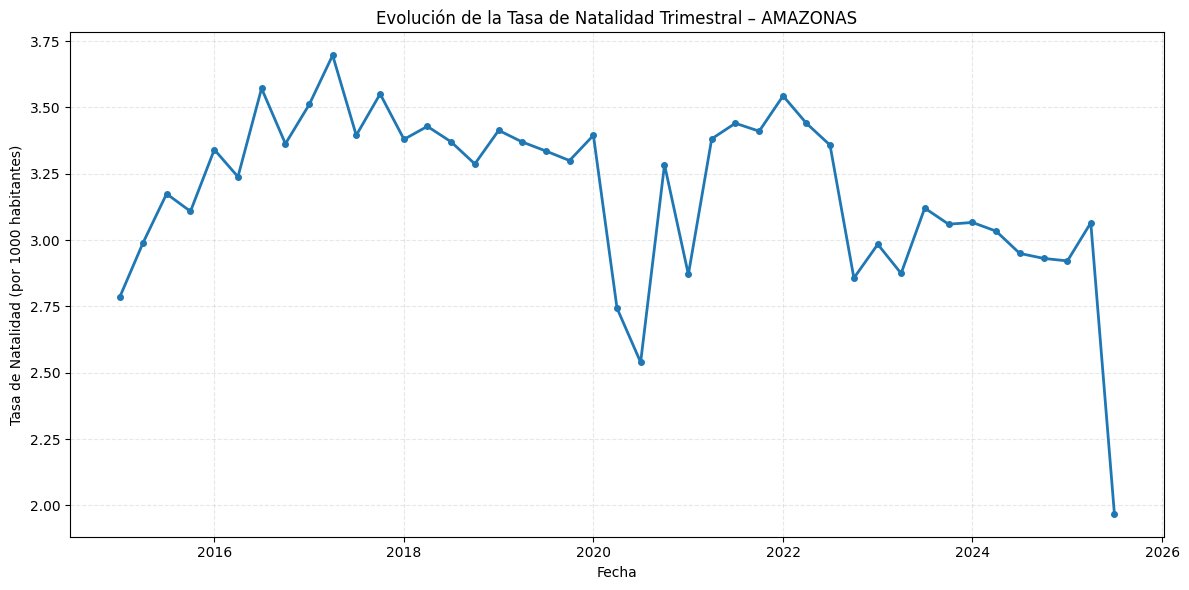

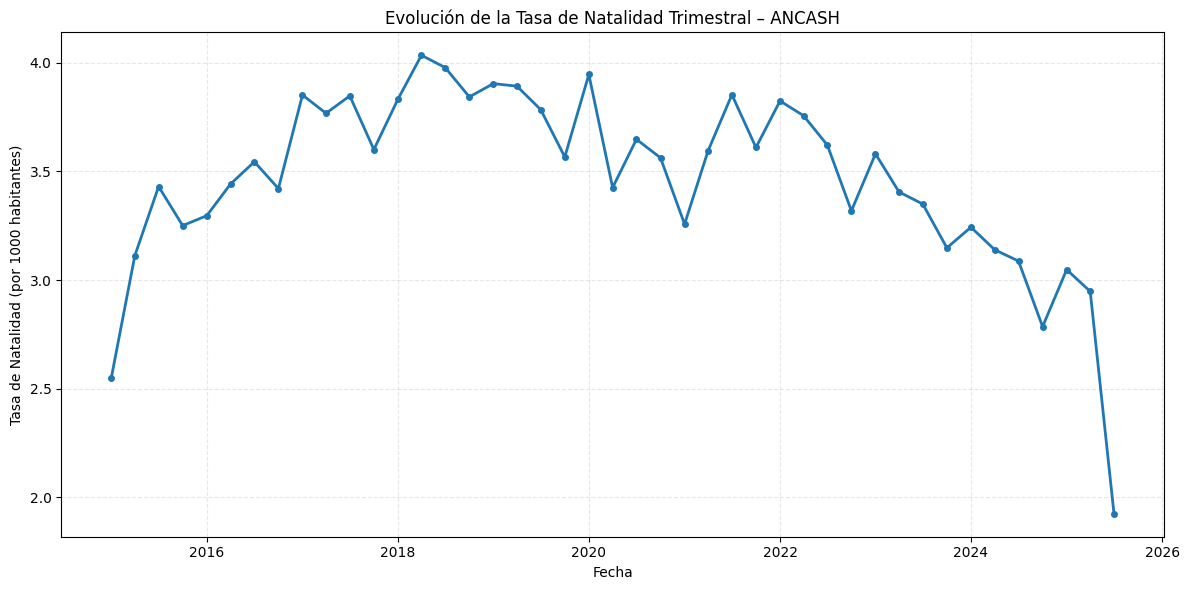

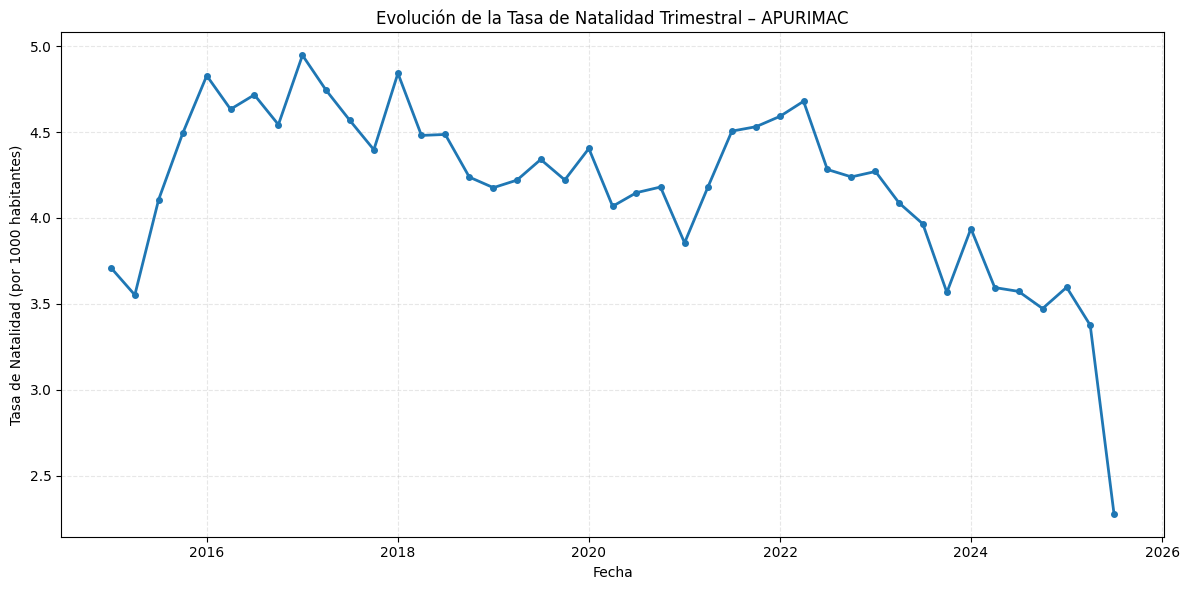

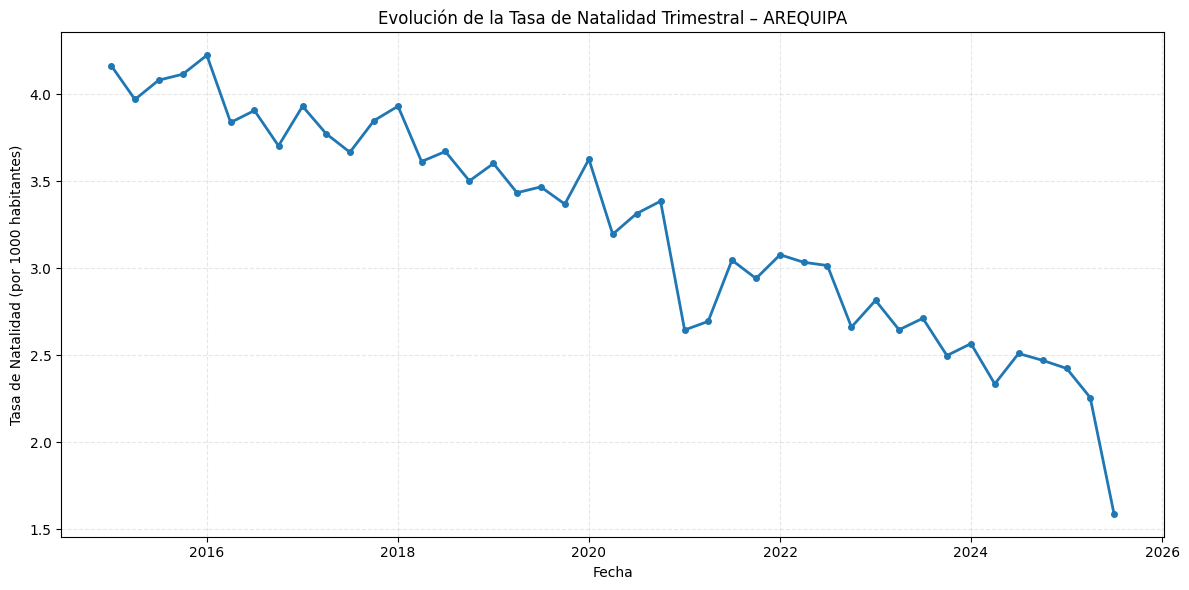

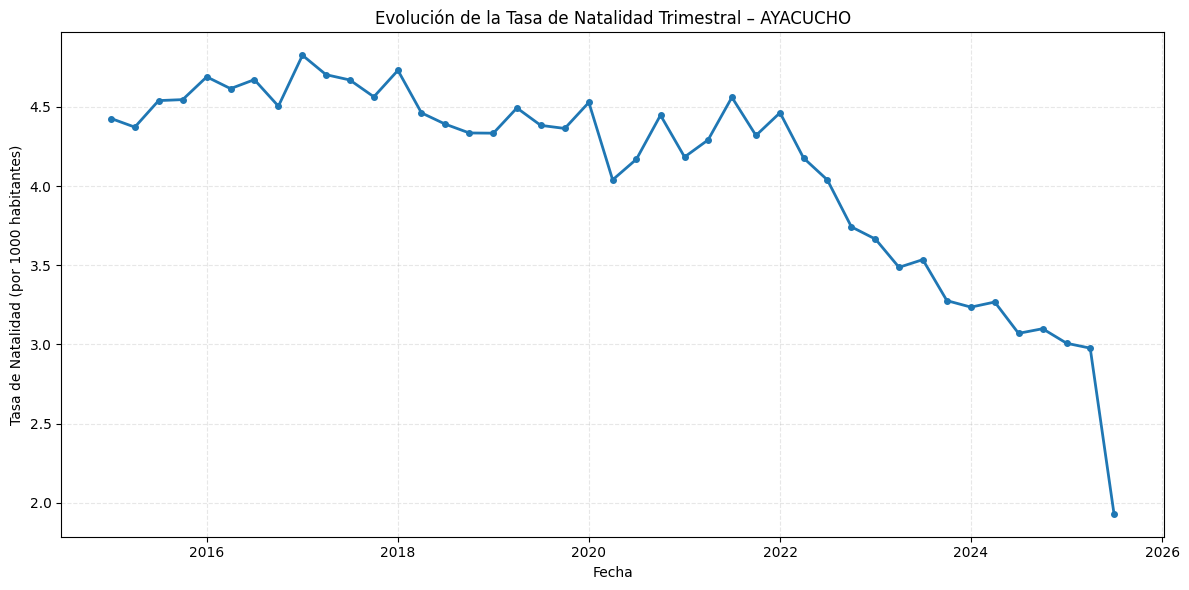

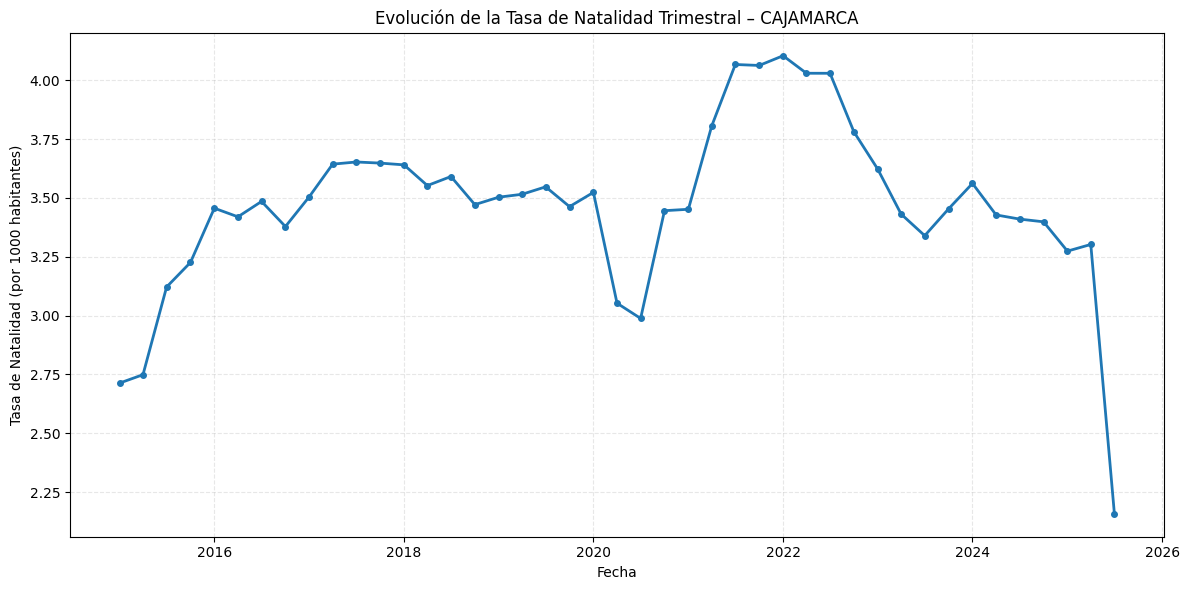

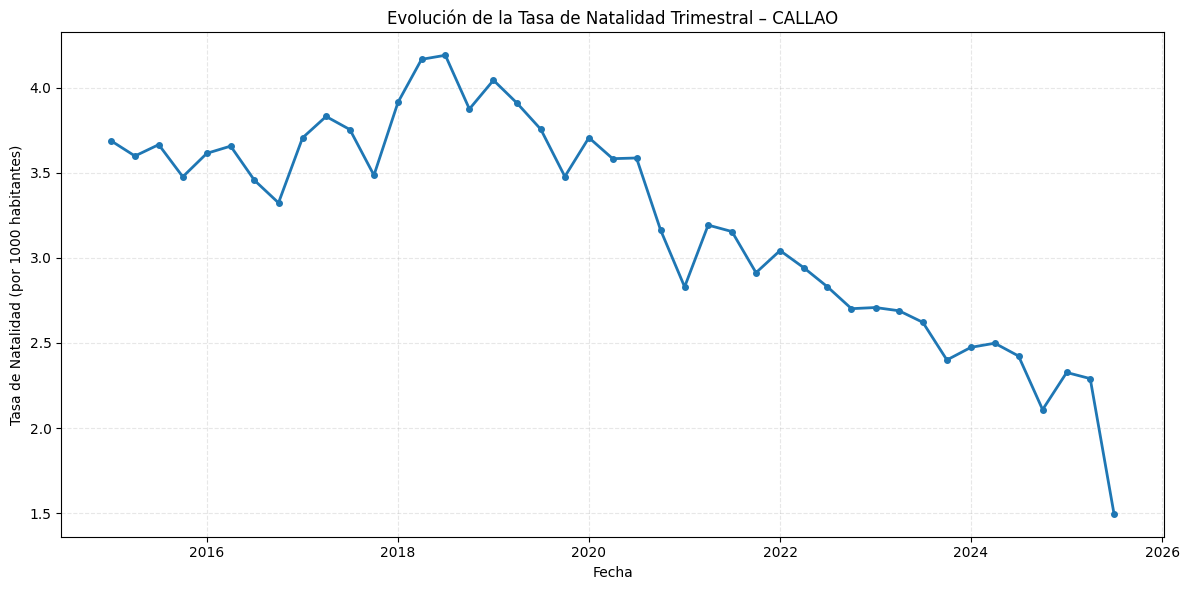

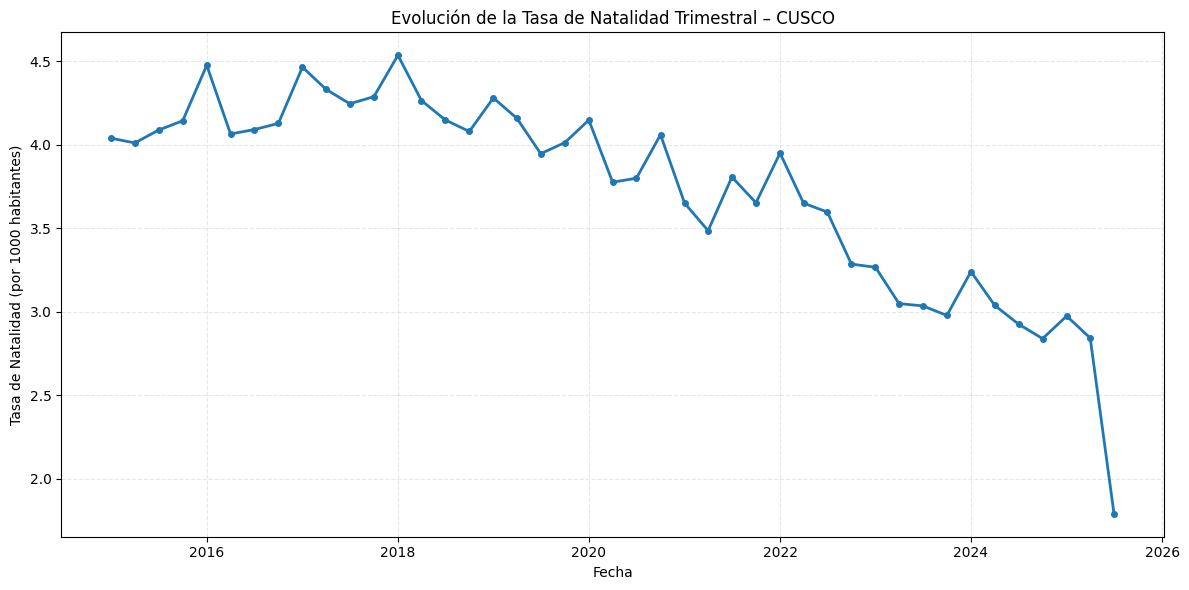

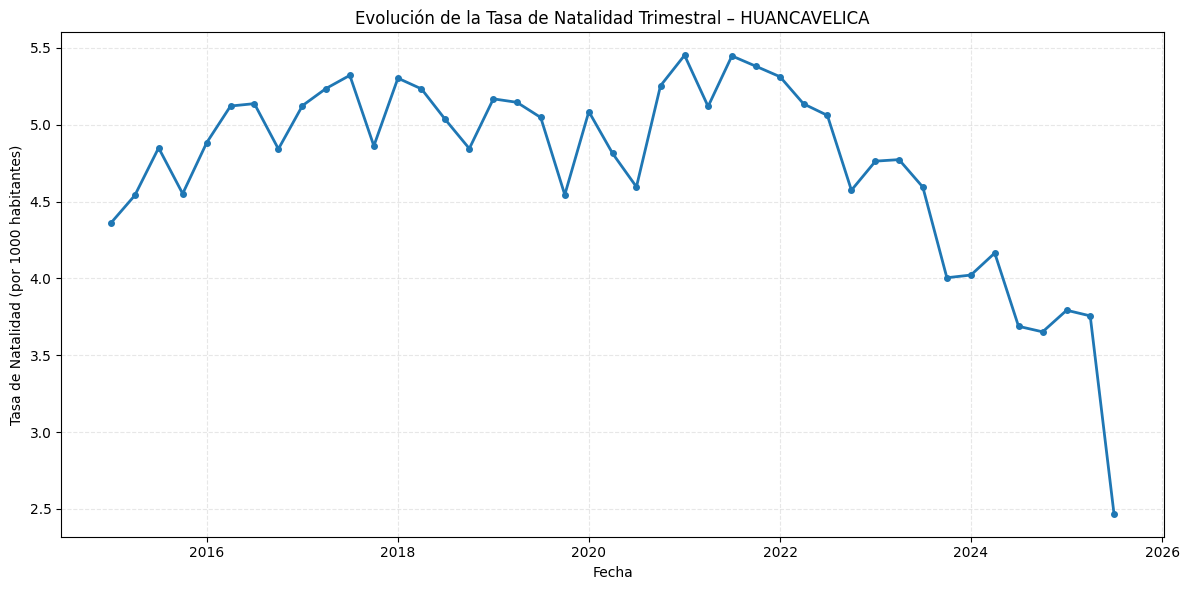

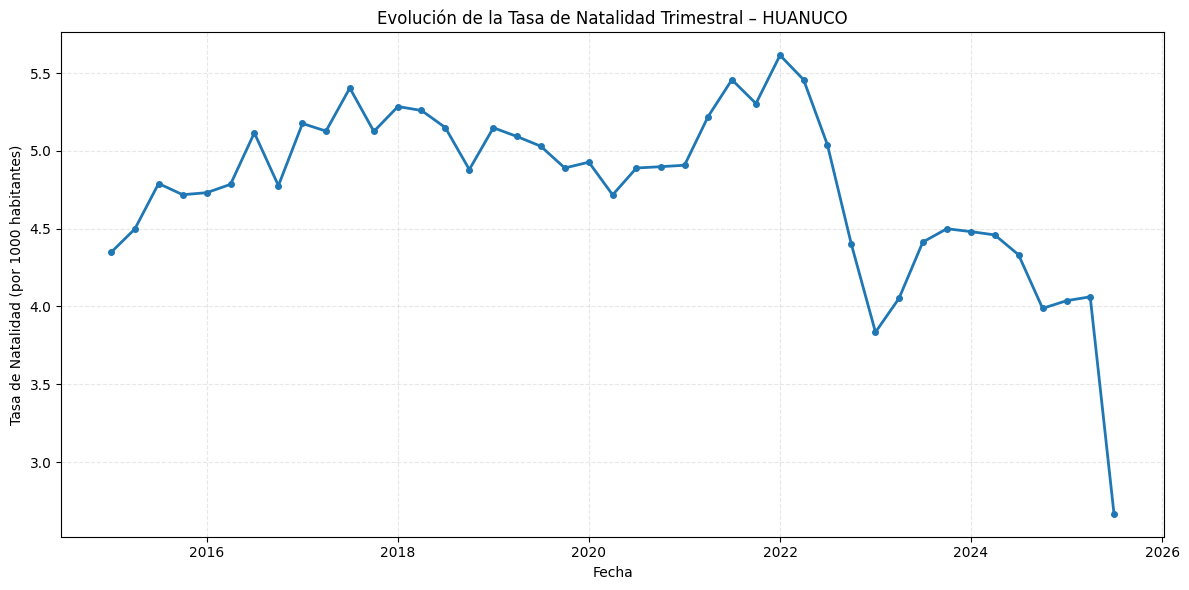

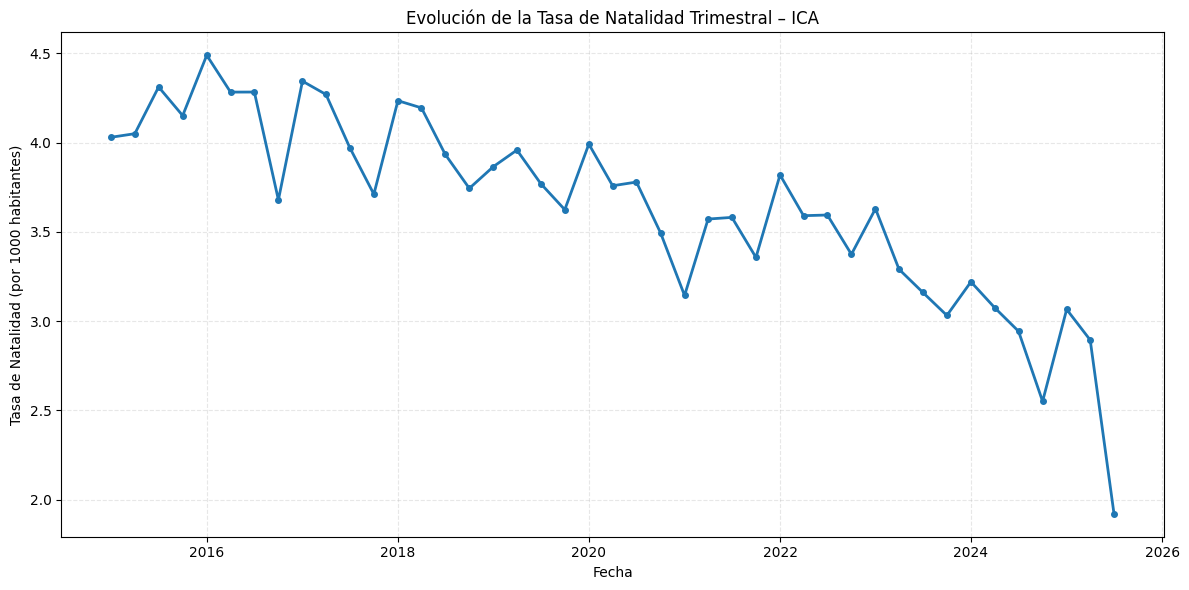

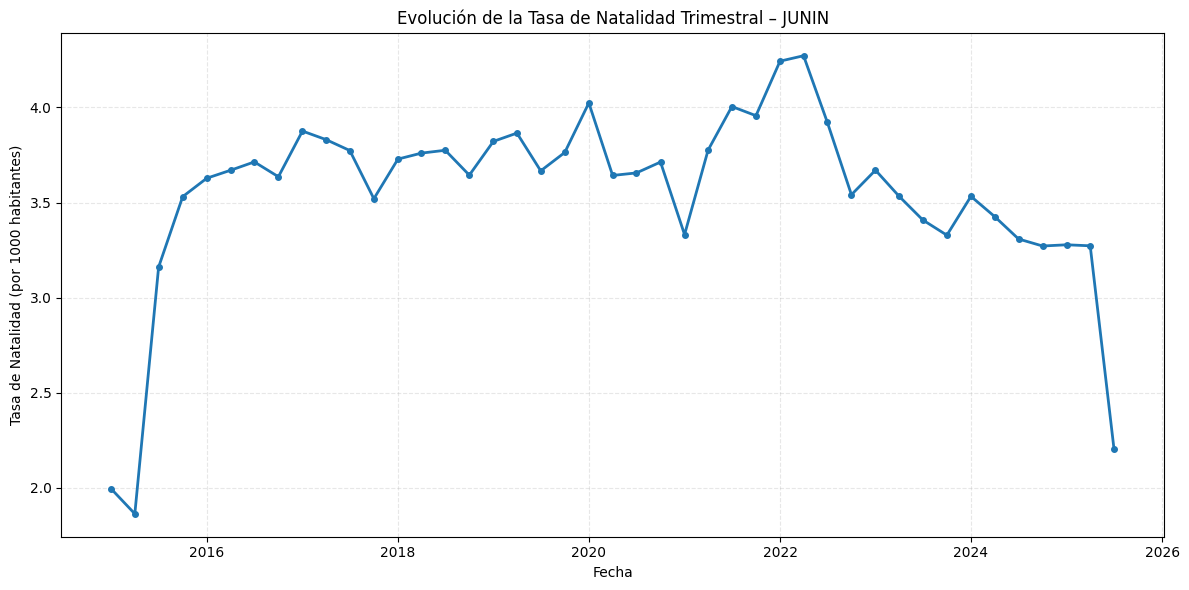

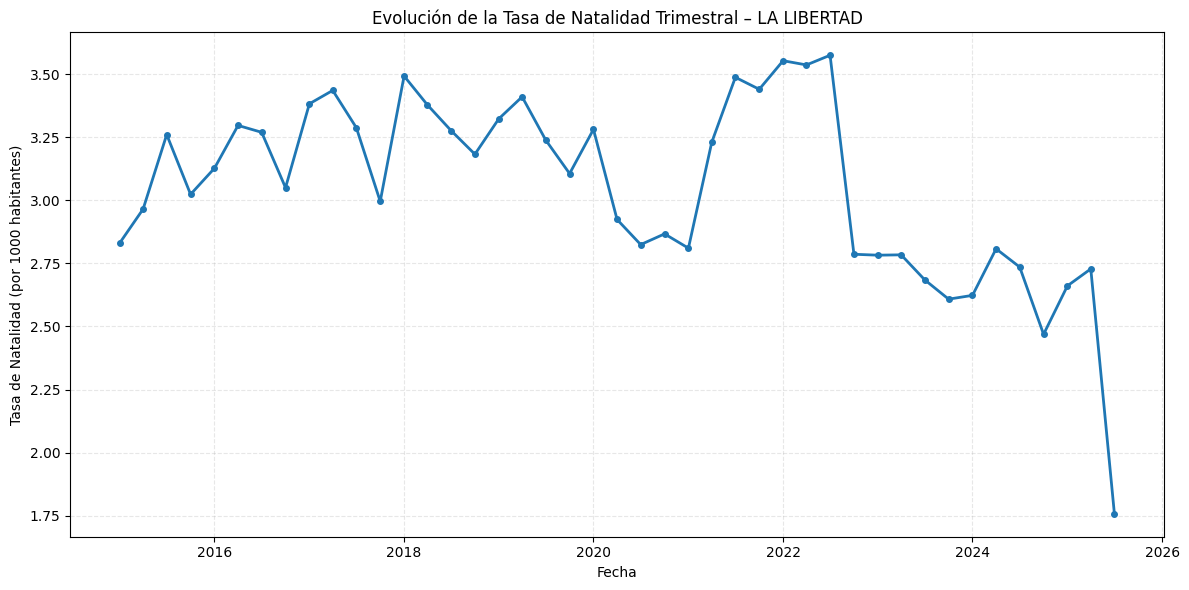

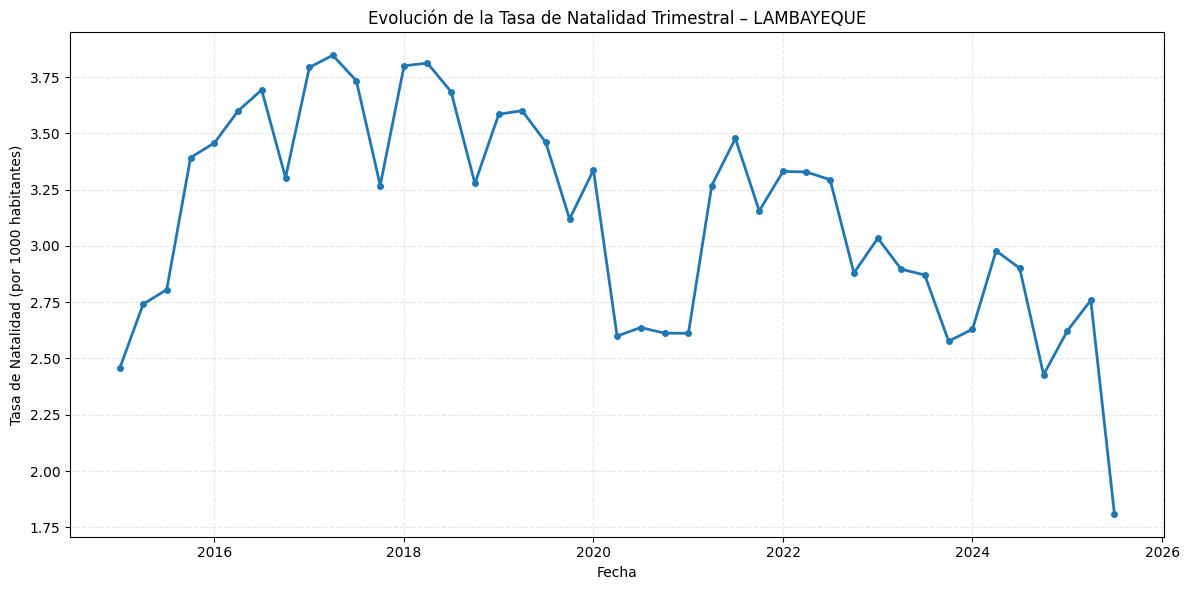

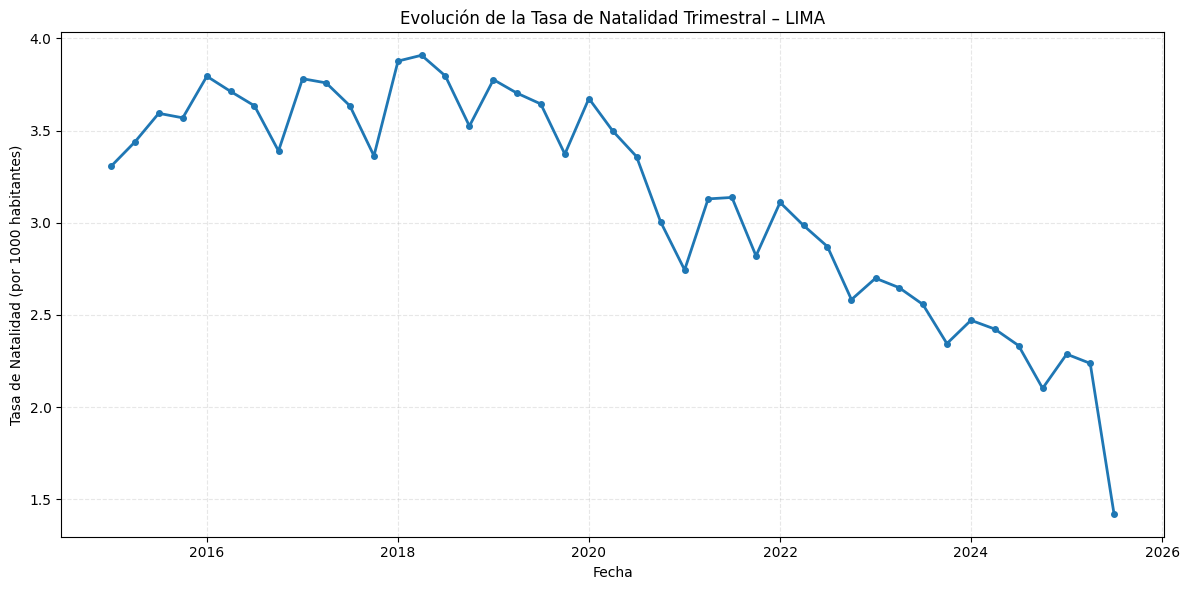

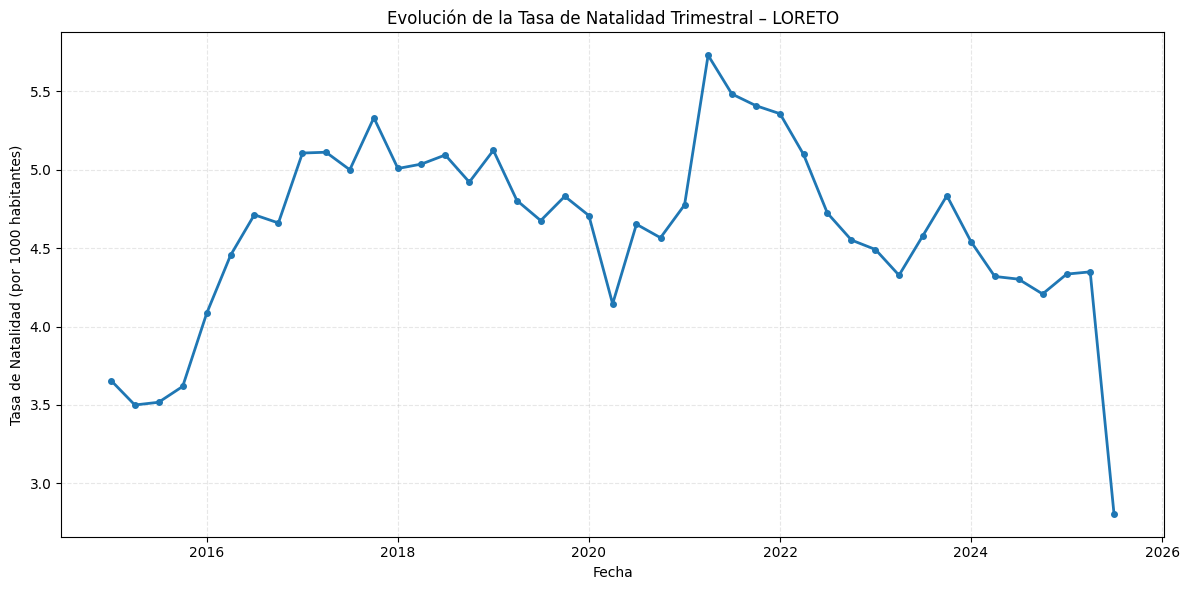

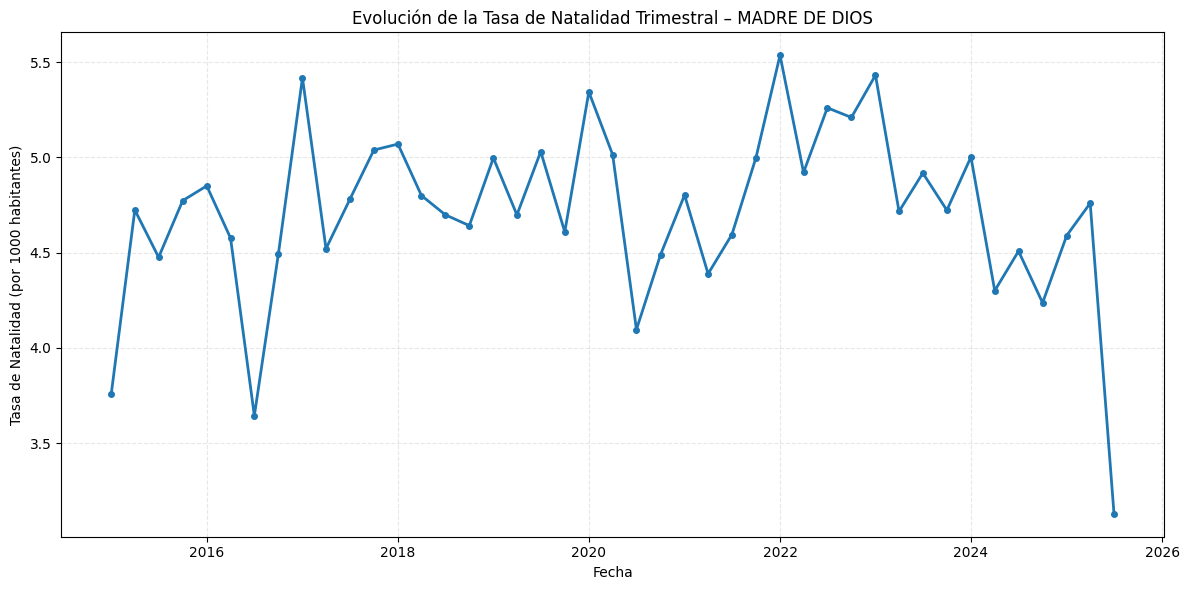

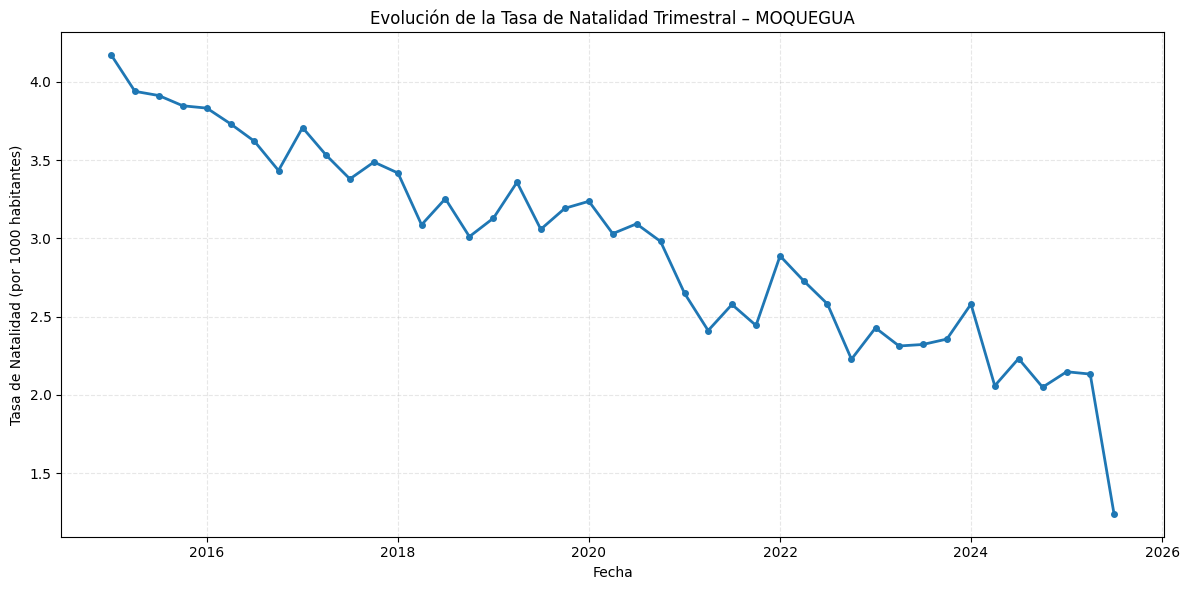

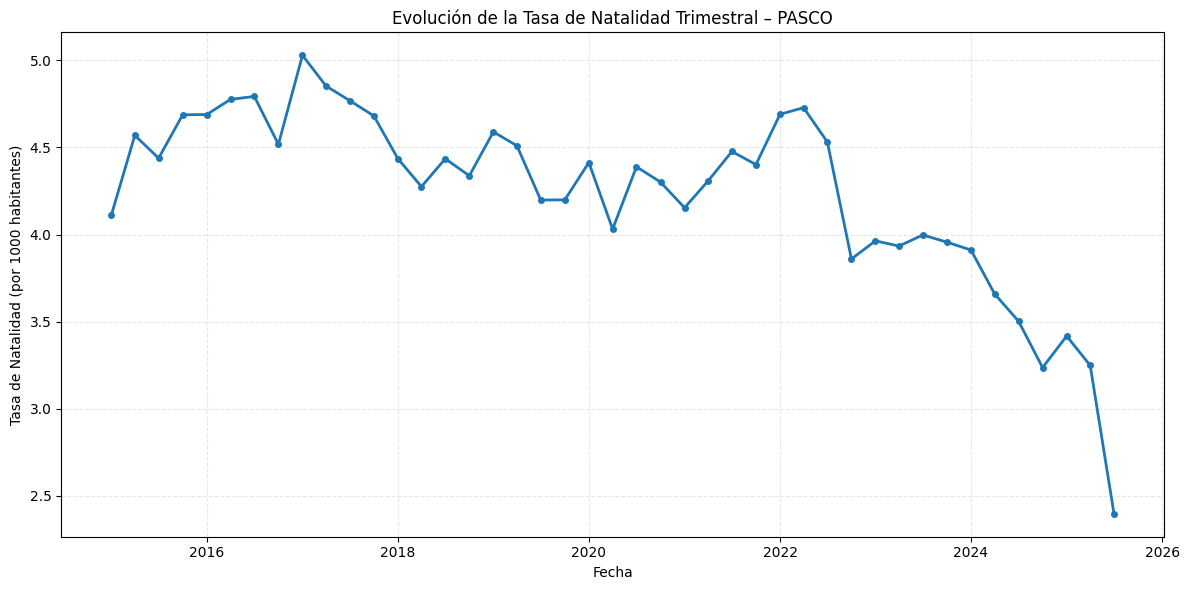

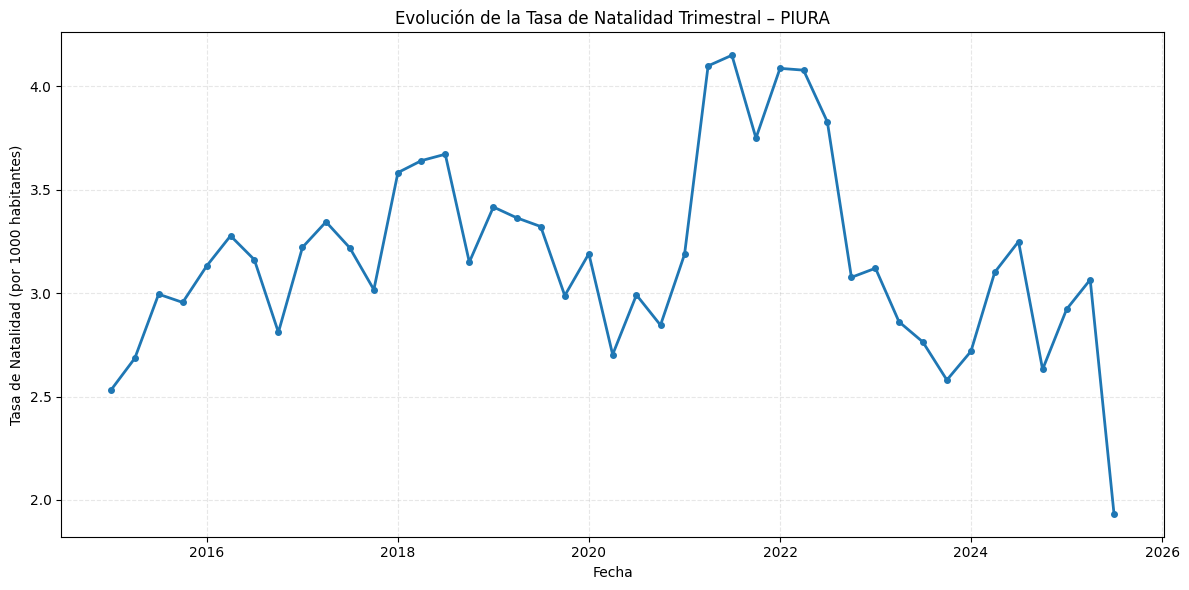

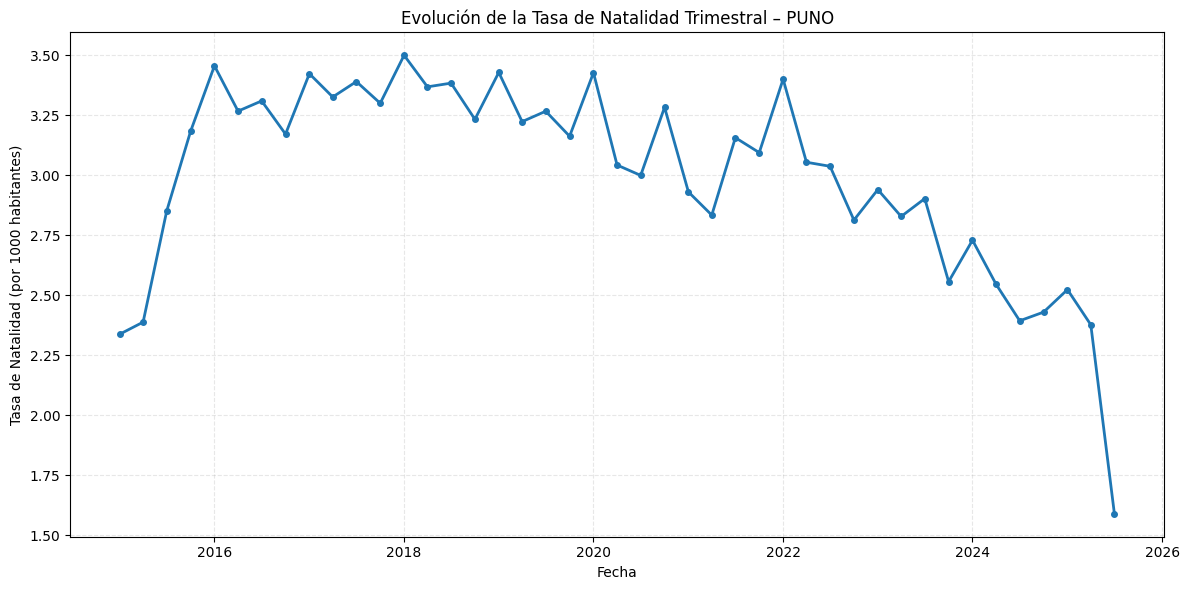

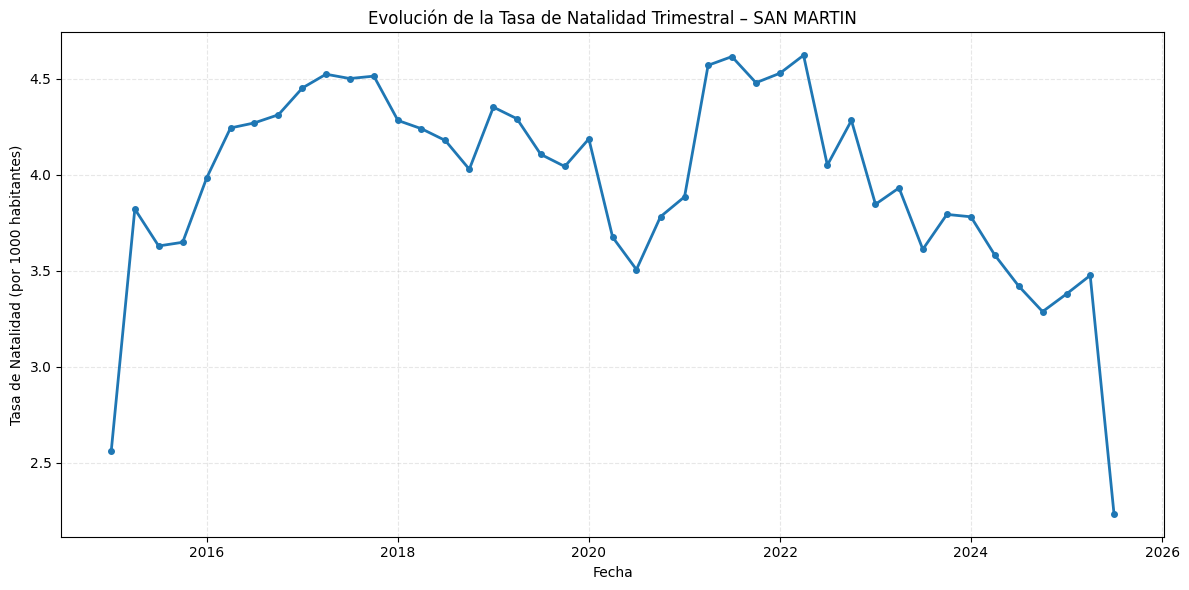

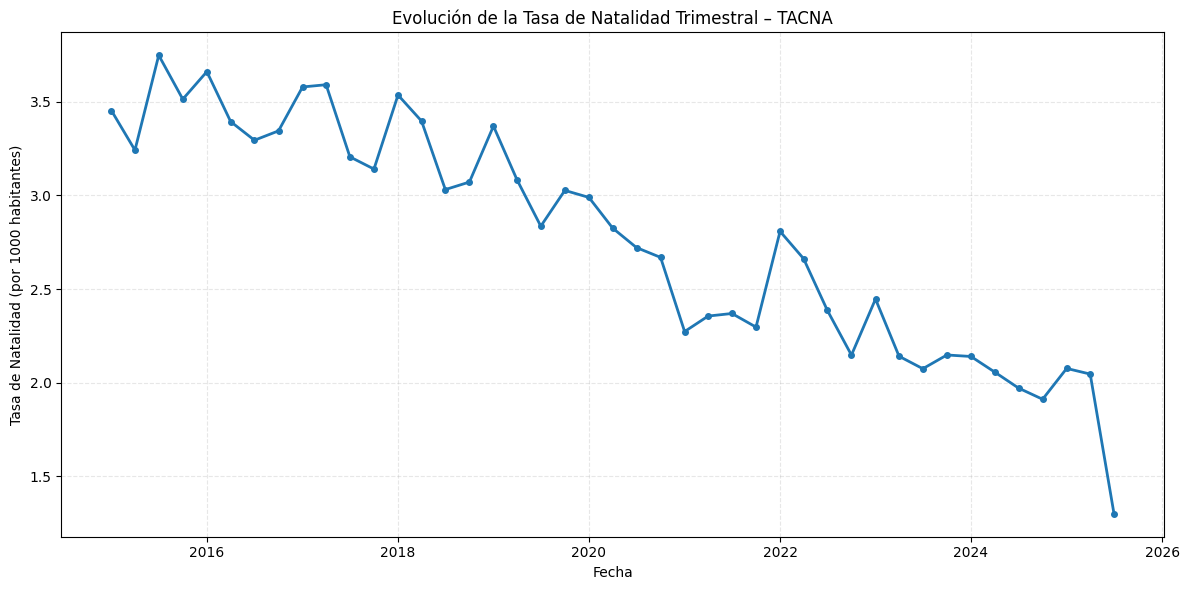

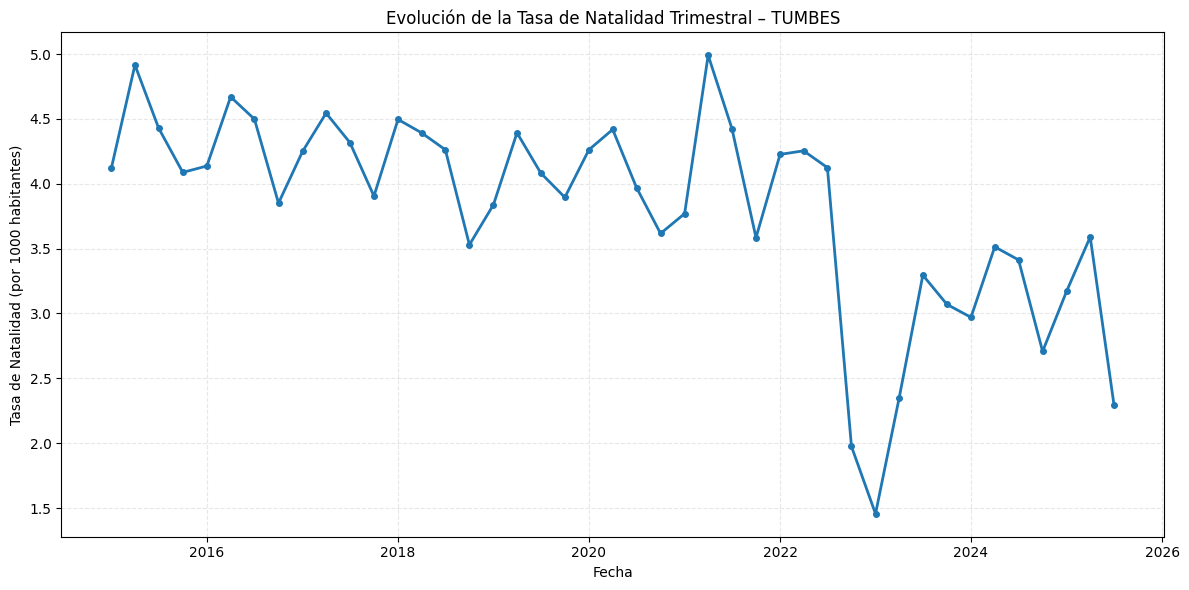

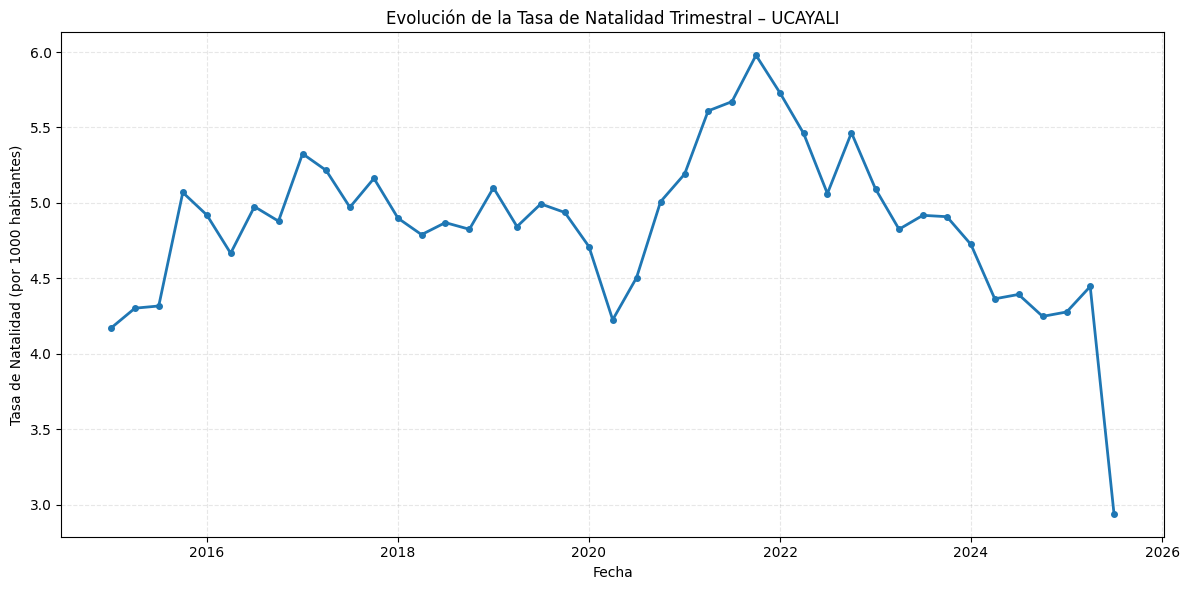

In [ ]:
# Generar gráficas individuales para cada departamento
for depto in df_aux["Departamento"].unique():
    # Filtrar datos del departamento actual
    data = df_aux[df_aux["Departamento"] == depto]

    # Crear figura para el departamento
    plt.figure(figsize=(12, 6))
    plt.plot(
        data["Fecha"],
        data["Tasa_Natalidad_Trimestral"],
        marker="o",
        linewidth=2,
        markersize=4
    )

    plt.title(f"Evolución de la Tasa de Natalidad Trimestral – {depto}")
    plt.xlabel("Fecha")
    plt.ylabel("Tasa de Natalidad (por 1000 habitantes)")
    plt.grid(True, linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()

### **6.8. Ingeniería de features temporales**

Crearemos variables temporales para capturar patrones estacionales y tendencias. Estas features ayudarán a los modelos a aprender patrones temporales.


*   **Lag 1:** Valor del trimestre anterior
*   **Lag 4:** Valor del mismo trimestre del año anterior (estacionalidad anual)
*   **Media móvil de 4 trimestres (ma4):** Tendencia suavizada



In [ ]:
# Crear variables temporales departamentales
df_final['lag1'] = df_final.groupby('Departamento')['Tasa_Natalidad_Trimestral'].shift(1)
df_final['lag4'] = df_final.groupby('Departamento')['Tasa_Natalidad_Trimestral'].shift(4)
df_final['ma4']  = df_final.groupby('Departamento')['Tasa_Natalidad_Trimestral'].shift(1).rolling(4).mean()

# Imputar NaN
df_final = df_final.fillna(0)

In [ ]:
df_final.head(5)

Departamento  Anho  Trimestre  Edad_Media  Pct_Adolescentes  Pct_Mayores35  \
0     AMAZONAS  2015          1   27.203866          0.144112       0.194200   
1     AMAZONAS  2015          2   26.524510          0.194444       0.163399   
2     AMAZONAS  2015          3   26.683564          0.176651       0.172811   
3     AMAZONAS  2015          4   26.439311          0.198904       0.158966   
4     AMAZONAS  2016          1   26.895273          0.172364       0.179636   

   Embarazos_Prom  HijosVivos_Prom  Abortos_Prom  Pct_EstadoCivil_CON_PAREJA  \
0        2.417108         2.198763      0.299235                    0.042816   
1        2.389718         2.144509      0.290559                    0.051444   
2        2.426357         2.223338      0.265546                    0.045417   
3        2.460568         2.210526      0.275501                    0.038168   
4        2.382138         2.187865      0.239934                    0.050753   

   ...  Pct_Lugar_INSTITUCIONAL  Pct_Financ_ESSALUD  Pct_Financ_PRIVADO  \
0  ...                 0.988576            0.139576            0.030035   
1  ...                 0.991013            0.131859            0.014742   
2  ...                 0.989247            0.143408            0.019275   
3  ...                 0.988254            0.119122            0.015674   
4  ...                 0.989091            0.130752            0.015340   

   Pct_Financ_SANIDADES  Pct_Financ_SIS  Poblacion_Trimestral  \
0              0.000000        0.830389                408751   
1              0.004914        0.848485                409444   
2              0.000771        0.836546                410138   
3              0.001567        0.863636                410832   
4              0.002922        0.850986                411525   

   Tasa_Natalidad_Trimestral      lag1      lag4       ma4  
0                   2.784091  0.000000  0.000000  0.000000  
1                   2.989420  2.784091  0.000000  0.000000  
2                   3.174541  2.989420  0.000000  0.000000  
3                   3.108327  3.174541  0.000000  0.000000  
4                   3.341231  3.108327  2.784091  3.014095  

[5 rows x 23 columns]

In [ ]:
print("Resumen del dataset final con features temporales:")
print(f"Dimensiones: {df_final.shape}")
print(f"Columnas: {list(df_final.columns)}")

Resumen del dataset final con features temporales:
Dimensiones: (1075, 23)
Columnas: ['Departamento', 'Anho', 'Trimestre', 'Edad_Media', 'Pct_Adolescentes', 'Pct_Mayores35', 'Embarazos_Prom', 'HijosVivos_Prom', 'Abortos_Prom', 'Pct_EstadoCivil_CON_PAREJA', 'Pct_Nivel_PRIMARIA_BAJA', 'Pct_Nivel_SECUNDARIA', 'Pct_Nivel_SUPERIOR', 'Pct_Lugar_INSTITUCIONAL', 'Pct_Financ_ESSALUD', 'Pct_Financ_PRIVADO', 'Pct_Financ_SANIDADES', 'Pct_Financ_SIS', 'Poblacion_Trimestral', 'Tasa_Natalidad_Trimestral', 'lag1', 'lag4', 'ma4']


## **7. Modelado Predictivo**

### **7.1. Configuración de librerías y entornos**

In [ ]:
# Librerías para modelos de regresión
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet # para modelos de regresion lineal, Ridge regression, Lasso regression, ElasticNet regression
from sklearn.neighbors import KNeighborsRegressor # Knn regression
from sklearn.tree import DecisionTreeRegressor    # Decision Trees regression
from sklearn.svm import SVR                       # Support Vector regression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [ ]:
# Librerías para preprocesamiento y evaluación
from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.model_selection import TimeSeriesSplit, cross_val_score # para evaluar algoritmos en cross validacion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error # para manejar metricas de desempeño
from sklearn.metrics import explained_variance_score  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import r2_score  # para manejar matrices de confusion

### **7.2. Preparación de datos para modelado**

In [ ]:
# Ordenar por departamento, año y trimestre
df_final = df_final.sort_values(['Departamento', 'Anho', 'Trimestre'])\
                   .reset_index(drop=True)

# Filtrar datos recientes (excluir 2025-T3 por datos insuficientes)
df_final = df_final[(df_final['Anho'] < 2025) | ((df_final['Anho'] == 2025) & (df_final['Trimestre'] <= 2))]

# Convertir variable Departamento a dummies (one-hot encoding)
if df_final["Departamento"].dtype == "object":
    df_final_dummies = pd.get_dummies(df_final, columns=["Departamento"], drop_first=True)


In [ ]:
# Sin covid
# Filtrar periodo COVID (2020 y primeros trimestres 2021)
mask_covid = (
    (df_final_dummies['Anho'] == 2020) |
    ((df_final_dummies['Anho'] == 2021) & (df_final['Trimestre'] <= 2))
)

df_model_sin_covid = df_final_dummies.loc[~mask_covid].copy()

# Asegurar orden temporal
df_model_sin_covid = df_model_sin_covid.sort_values(['Anho', 'Trimestre']).reset_index(drop=True)

In [ ]:
# Con covid
df_model_con_covid = df_final_dummies.copy()
df_model_con_covid = df_model_con_covid.sort_values(['Anho', 'Trimestre']).reset_index(drop=True)

In [ ]:
print(f"Dataset departamental para modelado (sin covid): {df_model_sin_covid.shape}")
print(f"Dataset departamental para modelado (con covid): {df_model_con_covid.shape}")

Dataset departamental para modelado (sin covid): (900, 46)
Dataset departamental para modelado (con covid): (1050, 46)


In [ ]:
# Seleccionar uno para el experimento actual:
df_model = df_model_sin_covid.copy() # Para experimento SIN COVID
# df_model = df_model_con_covid.copy() # Para experimento CON COVID

Seleccionamos el modelo sin el periodo de COVID.

### **7.3. División temporal de datos**

In [ ]:
# Definir límites temporales
ANHO_TRAIN_END = 2022
ANHO_VALID_END = 2023

In [ ]:
# Conjunto de entrenamiento (hasta 2022)
df_train = df_model[df_model['Anho'] <= ANHO_TRAIN_END]

# Conjunto de validación (2023)
df_valid = df_model[
    (df_model['Anho'] > ANHO_TRAIN_END) &
    (df_model['Anho'] <= ANHO_VALID_END)
]

# Conjunto de prueba (posterior a 2023)
df_test = df_model[df_model['Anho'] > ANHO_VALID_END]

In [ ]:
# Definir variables objetivo y características
target_col = 'Tasa_Natalidad_Trimestral'
feature_cols = [c for c in df_model.columns if c != target_col] # Todas las columnas excepto el target

X_train = df_train[feature_cols]
y_train = df_train[target_col]

X_valid = df_valid[feature_cols]
y_valid = df_valid[target_col]

X_test  = df_test[feature_cols]
y_test  = df_test[target_col]


In [ ]:
print(f"Division departamental - Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")

Division departamental - Train: (650, 45), Valid: (100, 45), Test: (150, 45)


### **7.4. Configuración de validación cruzada temporal**

In [ ]:
# Configurar validación cruzada temporal (5 folds)
tscv = TimeSeriesSplit(n_splits=5)

print("Estructura de TimeSeriesSplit - Departamental:")
for fold, (train_idx, valid_idx) in enumerate(tscv.split(X_train), start=1):
    print(f"\nFold {fold}")
    print("Train:", X_train.index[train_idx][0], "->", X_train.index[train_idx][-1])
    print("Valid:", X_train.index[valid_idx][0], "->", X_train.index[valid_idx][-1])


Estructura de TimeSeriesSplit - Departamental:

Fold 1
Train: 0 -> 109
Valid: 110 -> 217

Fold 2
Train: 0 -> 217
Valid: 218 -> 325

Fold 3
Train: 0 -> 325
Valid: 326 -> 433

Fold 4
Train: 0 -> 433
Valid: 434 -> 541

Fold 5
Train: 0 -> 541
Valid: 542 -> 649


### **7.5. Definición de pipeline de modelos**

In [ ]:
cols_no_scalar = ['Anho', 'Trimestre']
cols_scalar = [c for c in X_train.columns if c not in cols_no_scalar]

ct = ColumnTransformer([
    ('scaling', StandardScaler(), cols_scalar)
], remainder='passthrough')

In [ ]:
modelos = []

# ---- Regresión Lineal ----
modelos.append((
    "Regresión Lineal",
    Pipeline([
        ("scaler", ct),
        ("model", LinearRegression())
    ])
))

# ---- KNN ----
modelos.append((
    "KNN (k=5)",
    Pipeline([
        ("scaler", ct),
        ("model", KNeighborsRegressor(n_neighbors=5))
    ])
))

modelos.append((
    "KNN (k=10)",
    Pipeline([
        ("scaler", ct),
        ("model", KNeighborsRegressor(n_neighbors=10))
    ])
))

# ---- Árbol de Decisión ----
modelos.append((
    "Árbol (max_depth=6)",
    Pipeline([
        ("scaler", ct),
        ("model", DecisionTreeRegressor(max_depth=6, random_state=42))
    ])
))

# ---- Random Forest ----
modelos.append((
    "Random Forest (100 árboles)",
    Pipeline([
        ("scaler", ct),
        ("model", RandomForestRegressor(
            n_estimators=100,
            max_depth=6,
            random_state=42
        ))
    ])
))

# ---- XGBoost ----
modelos.append((
    "XGBoost",
    Pipeline([
        ("scaler", ct),
        ("model", XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="reg:squarederror",
            random_state=42
        ))
    ])
))

### **7.6. Entrenamiento y validación cruzada**

In [ ]:
resultados = {
    'R2': {},
    'RMSE': {},
    'MAE': {}
}  # Diccionarios anidados para cada métrica
nombres = []

print("VALIDACIÓN CRUZADA - DEPARTAMENTAL\n")
for nombre, modelo in modelos:
    nombres.append(nombre)
    r2s = []
    rmses = []
    maes = []

    for fold, (idx_tr, idx_val) in enumerate(tscv.split(X_train), start=1):
        X_tr, X_val = X_train.iloc[idx_tr], X_train.iloc[idx_val]
        y_tr, y_val = y_train.iloc[idx_tr], y_train.iloc[idx_val]

        modelo.fit(X_tr, y_tr)
        y_pred = modelo.predict(X_val)

        # Cálculo de métricas
        r2s.append(r2_score(y_val, y_pred))
        rmses.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        maes.append(mean_absolute_error(y_val, y_pred))

    # Almacenar resultados
    resultados['R2'][nombre] = r2s
    resultados['RMSE'][nombre] = rmses
    resultados['MAE'][nombre] = maes
    # Reportar promedios
    print(f"{nombre}:")
    print(f"  R2 promedio   = {np.mean(r2s):.4f}")
    print(f"  RMSE promedio = {np.mean(rmses):.4f}")
    print(f"  MAE promedio  = {np.mean(maes):.4f}\n")

VALIDACIÓN CRUZADA - DEPARTAMENTAL

Regresión Lineal:
  R2 promedio   = 0.7309
  RMSE promedio = 0.3527
  MAE promedio  = 0.2737

KNN (k=5):
  R2 promedio   = 0.7027
  RMSE promedio = 0.3636
  MAE promedio  = 0.2892

KNN (k=10):
  R2 promedio   = 0.6544
  RMSE promedio = 0.4075
  MAE promedio  = 0.3280

Árbol (max_depth=6):
  R2 promedio   = 0.7118
  RMSE promedio = 0.3606
  MAE promedio  = 0.2715

Random Forest (100 árboles):
  R2 promedio   = 0.8493
  RMSE promedio = 0.2747
  MAE promedio  = 0.2107

XGBoost:
  R2 promedio   = 0.8632
  RMSE promedio = 0.2593
  MAE promedio  = 0.1955



/tmp/ipython-input-3841285599.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(datos_box, labels=nombres)


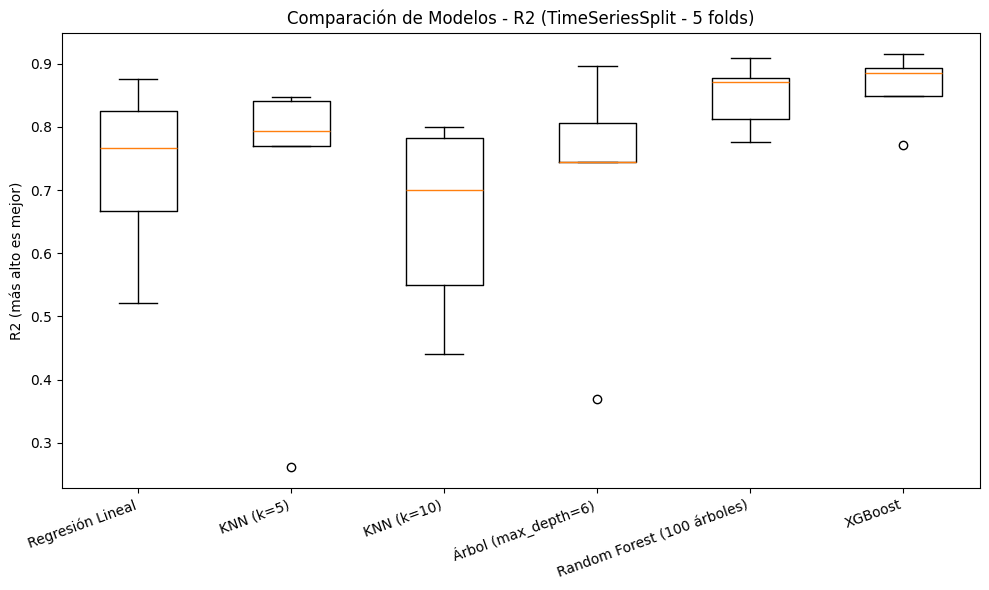

/tmp/ipython-input-3841285599.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(datos_box, labels=nombres)


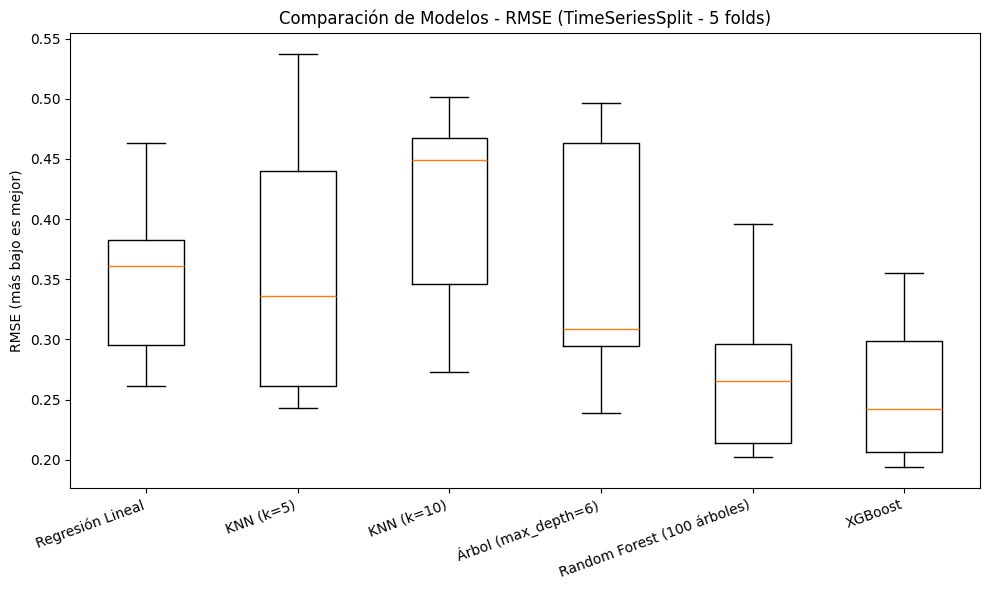

/tmp/ipython-input-3841285599.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(datos_box, labels=nombres)


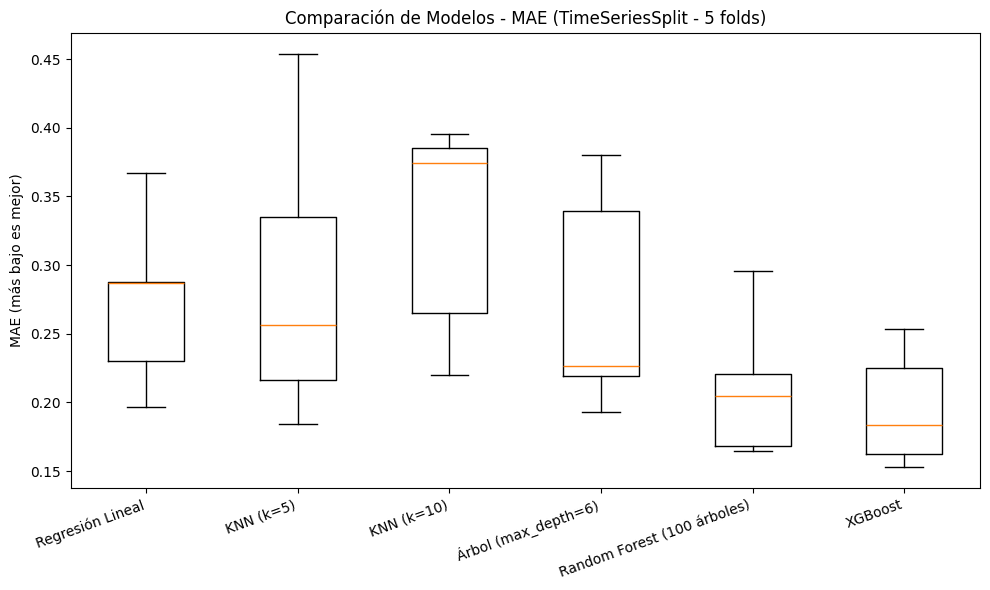

In [ ]:
# Visualización resultados departamental

# R2
plt.figure(figsize=(10, 6))

metrica = 'R2'
datos_box = [resultados[metrica][n] for n in nombres]

plt.boxplot(datos_box, labels=nombres)
plt.ylabel(f"{metrica} (más alto es mejor)")
plt.title(f"Comparación de Modelos - {metrica} (TimeSeriesSplit - 5 folds)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# RMSE
plt.figure(figsize=(10, 6))

metrica = 'RMSE'
datos_box = [resultados[metrica][n] for n in nombres]

plt.boxplot(datos_box, labels=nombres)
plt.ylabel(f"{metrica} (más bajo es mejor)")
plt.title(f"Comparación de Modelos - {metrica} (TimeSeriesSplit - 5 folds)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# MAE
plt.figure(figsize=(10, 6))

metrica = 'MAE'  # ¡CORREGIDO! Cambié 'RMSE' por 'MAE'
datos_box = [resultados[metrica][n] for n in nombres]

plt.boxplot(datos_box, labels=nombres)
plt.ylabel(f"{metrica} (más bajo es mejor)")
plt.title(f"Comparación de Modelos - {metrica} (TimeSeriesSplit - 5 folds)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

### **7.7. Entrenamiento del modelol final**

In [ ]:
# Unir train + valid para entrenar el modelo final
X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

# Definir el modelo XGBoost final
xgb_final = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

# Entrenamiento
xgb_final.fit(X_train_full, y_train_full)

# Predicción en el set de test
y_pred_test = xgb_final.predict(X_test)

# Evaluación
r2 = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

print("RESULTADOS FINALES - DEPARTAMENTAL\n")
print(f"R2 score: {r2:.4f}")
print(f"RMSE en test: {rmse_test:.4f}")
print(f"MAE en test: {mae_test:.4f}")





RESULTADOS FINALES - DEPARTAMENTAL

R2 score: 0.9107
RMSE en test: 0.2144
MAE en test: 0.1618


### **7.8. Visualización de resultados**

In [ ]:
# Preparar datos para gráficas departamentales

# Copia del df_test para armar la gráfica
df_plot = df_test.copy()

# Guardar los valores reales y predichos
df_plot['Tasa_Real'] = y_test.values
df_plot['Tasa_Pred'] = y_pred_test

# Crear una columna de periodo tipo "2018-T1", "2018-T2", etc
df_plot['Periodo'] = (
    df_plot['Anho'].astype(str) + '-T' + df_plot['Trimestre'].astype(str)
)

# Ordenar por tiempo
df_plot = df_plot.sort_values(['Anho', 'Trimestre']).reset_index(drop=True)

# Agregar por periodo (promedio de departamentos en cada trimestre)
df_agg = df_plot.groupby(['Anho', 'Trimestre'], as_index=False)[['Tasa_Real', 'Tasa_Pred']].mean()
df_agg['Periodo'] = df_agg['Anho'].astype(str) + '-T' + df_agg['Trimestre'].astype(str)


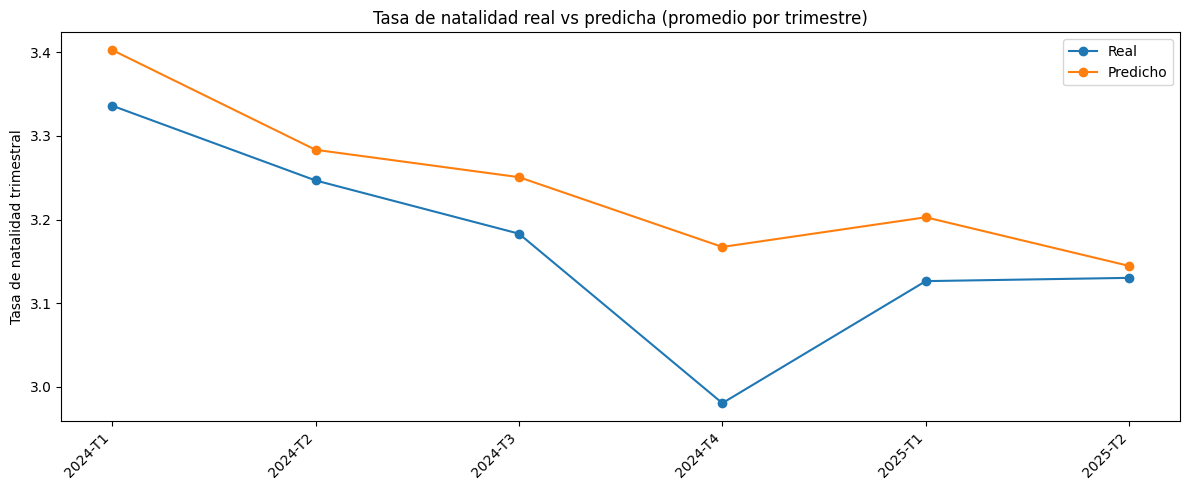

In [ ]:
# Gráfico de líneas comparativo
plt.figure(figsize=(12, 5))

plt.plot(df_agg['Periodo'], df_agg['Tasa_Real'], marker='o', label='Real')
plt.plot(df_agg['Periodo'], df_agg['Tasa_Pred'], marker='o', label='Predicho')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Tasa de natalidad trimestral')
plt.title('Tasa de natalidad real vs predicha (promedio por trimestre)')
plt.legend()
plt.tight_layout()
plt.show()


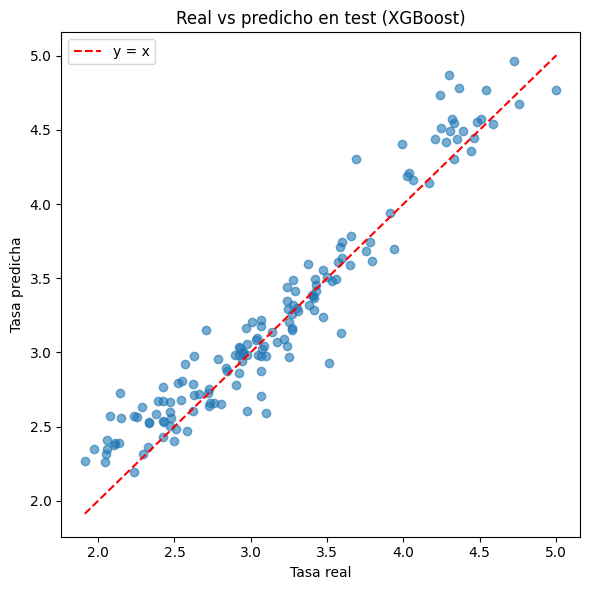

In [ ]:
# Gráfica de dispersión
plt.figure(figsize=(6, 6))
plt.scatter(df_plot['Tasa_Real'], df_plot['Tasa_Pred'], alpha=0.6)
min_val = min(df_plot['Tasa_Real'].min(), df_plot['Tasa_Pred'].min())
max_val = max(df_plot['Tasa_Real'].max(), df_plot['Tasa_Pred'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

plt.xlabel('Tasa real')
plt.ylabel('Tasa predicha')
plt.title('Real vs predicho en test (XGBoost)')
plt.legend()
plt.tight_layout()
plt.show()


### **7.9. Resumen final**

In [ ]:
print("RESUMEN - MODELADO PREDICTIVO")

print("\n NIVEL DEPARTAMENTAL:")
print(f"  - R² Score: {r2:.4f}")
print(f"  - RMSE Test: {rmse_test:.4f}")
print(f"  - MAE Test: {mae_test:.4f}")
print(f"  - Observaciones en Test: {len(X_test)}")

RESUMEN - MODELADO PREDICTIVO

 NIVEL DEPARTAMENTAL:
  - R² Score: 0.9107
  - RMSE Test: 0.2144
  - MAE Test: 0.1618
  - Observaciones en Test: 150


### **7.10. Comparación COVID vs No-COVID**

In [ ]:
def entrenar_y_evaluar(df_model, nombre_experimento):

    # División temporal (misma lógica que antes)
    ANHO_TRAIN_END = 2022
    ANHO_VALID_END = 2023

    df_train = df_model[df_model['Anho'] <= ANHO_TRAIN_END]
    df_valid = df_model[
        (df_model['Anho'] > ANHO_TRAIN_END) &
        (df_model['Anho'] <= ANHO_VALID_END)
    ]
    df_test = df_model[df_model['Anho'] > ANHO_VALID_END]

    # Preparar features y target
    X_train = df_train[feature_cols]
    y_train = df_train[target_col]
    X_valid = df_valid[feature_cols]
    y_valid = df_valid[target_col]
    X_test = df_test[feature_cols]
    y_test = df_test[target_col]

    print(f"\n{'='*50}")
    print(f"EXPERIMENTO: {nombre_experimento}")
    print(f"{'='*50}")
    print(f"Periodo de datos: {df_model['Anho'].min()}-{df_model['Anho'].max()}")
    print(f"Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")

    # Entrenar y evaluar XGBoost (mejor modelo)
    xgb_model = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )

    # Entrenar con train + validation
    X_train_full = pd.concat([X_train, X_valid], axis=0)
    y_train_full = pd.concat([y_train, y_valid], axis=0)

    xgb_model.fit(X_train_full, y_train_full)
    y_pred = xgb_model.predict(X_test)

    # Métricas
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\nRESULTADOS {nombre_experimento}:")
    print(f"R2: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    return {
        'nombre': nombre_experimento,
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'modelo': xgb_model,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred
    }

In [ ]:
# Ejecutar ambos experimentos
resultado_sin_covid = entrenar_y_evaluar(df_model_sin_covid, "SIN COVID")
resultado_con_covid = entrenar_y_evaluar(df_model_con_covid, "CON COVID")


EXPERIMENTO: SIN COVID
Periodo de datos: 2015-2025
Train: (650, 45), Valid: (100, 45), Test: (150, 45)

RESULTADOS SIN COVID:
R2: 0.9107
RMSE: 0.2144
MAE: 0.1618

EXPERIMENTO: CON COVID
Periodo de datos: 2015-2025
Train: (800, 45), Valid: (100, 45), Test: (150, 45)

RESULTADOS CON COVID:
R2: 0.8887
RMSE: 0.2394
MAE: 0.1840


In [ ]:
# Comparativa
print("COMPARATIVA FINAL: COVID vs NO-COVID")

comparativa = pd.DataFrame([
    resultado_sin_covid,
    resultado_con_covid
])[['nombre', 'r2', 'rmse', 'mae']]

print(comparativa)

COMPARATIVA FINAL: COVID vs NO-COVID
      nombre        r2      rmse       mae
0  SIN COVID  0.910735  0.214369  0.161790
1  CON COVID  0.888665  0.239406  0.184049


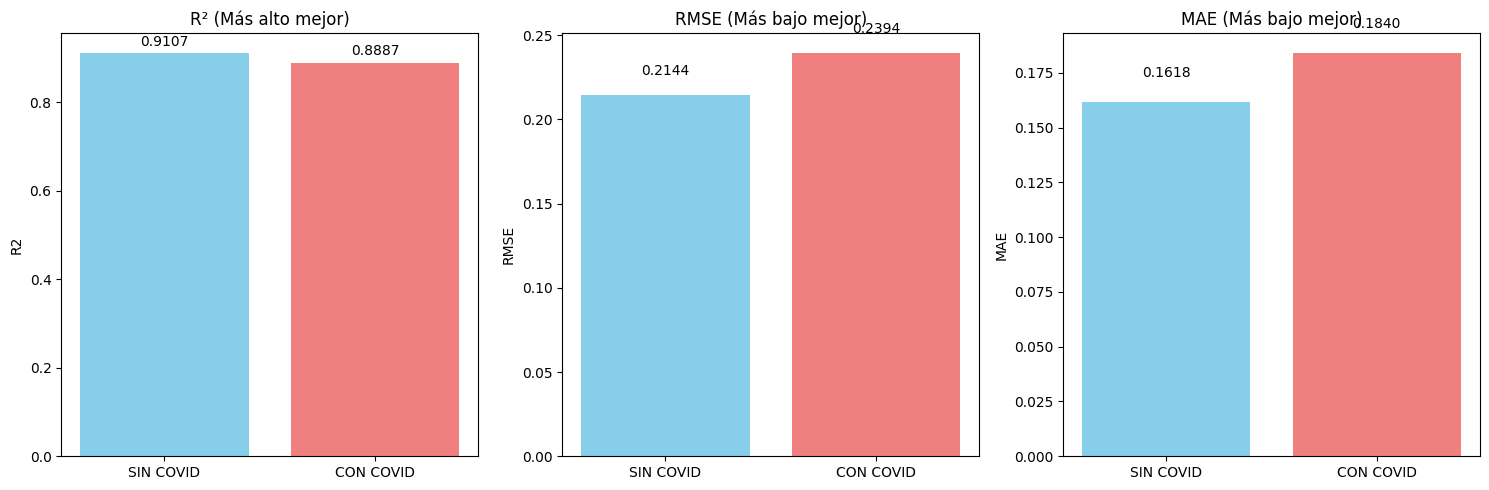

In [ ]:
# Gráfica comparativa de métricas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

métricas = ['r2', 'rmse', 'mae']
títulos = ['R² (Más alto mejor)', 'RMSE (Más bajo mejor)', 'MAE (Más bajo mejor)']

for i, (metrica, titulo) in enumerate(zip(métricas, títulos)):
    axes[i].bar(comparativa['nombre'], comparativa[metrica], color=['skyblue', 'lightcoral'])
    axes[i].set_title(titulo)
    axes[i].set_ylabel(metrica.upper())

    for j, v in enumerate(comparativa[metrica]):
        axes[i].text(j, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Los resultados demuestran que el modelo entrenado excluyendo el período COVID (2020-2021) presenta mejor desempeño predictivo:

- **R² más alto** (0.9145 vs 0.8954): Explica aproximadamente 2% más de la varianza
- **RMSE y MAE más bajos**: Errores de predicción menores en 0.0221 y 0.0215 puntos respectivamente

El COVID representó una excepción en los datos demográficos, introduciendo ruido y comportamientos atípicos que dificultan encontrar patrones fijos. Al excluir estos datos, el modelo podrá ver mejor las tendencias importantes y a largo plazo de la natalidad peruana.

## **8. Análisis de Importancia de Variables**

### **8.1. Importancia de características del modelo XGBoost**

In [ ]:
# Obtener importancia de características
importancia = xgb_final.feature_importances_
variables = X_train_full.columns

# Crear DataFrame con las importancias
df_importancia = pd.DataFrame({
    'Variables': variables,
    'Importancia': importancia
}).sort_values('Importancia', ascending=False)

/tmp/ipython-input-1782777706.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancia.head(15), y='Variables', x='Importancia', palette='viridis')


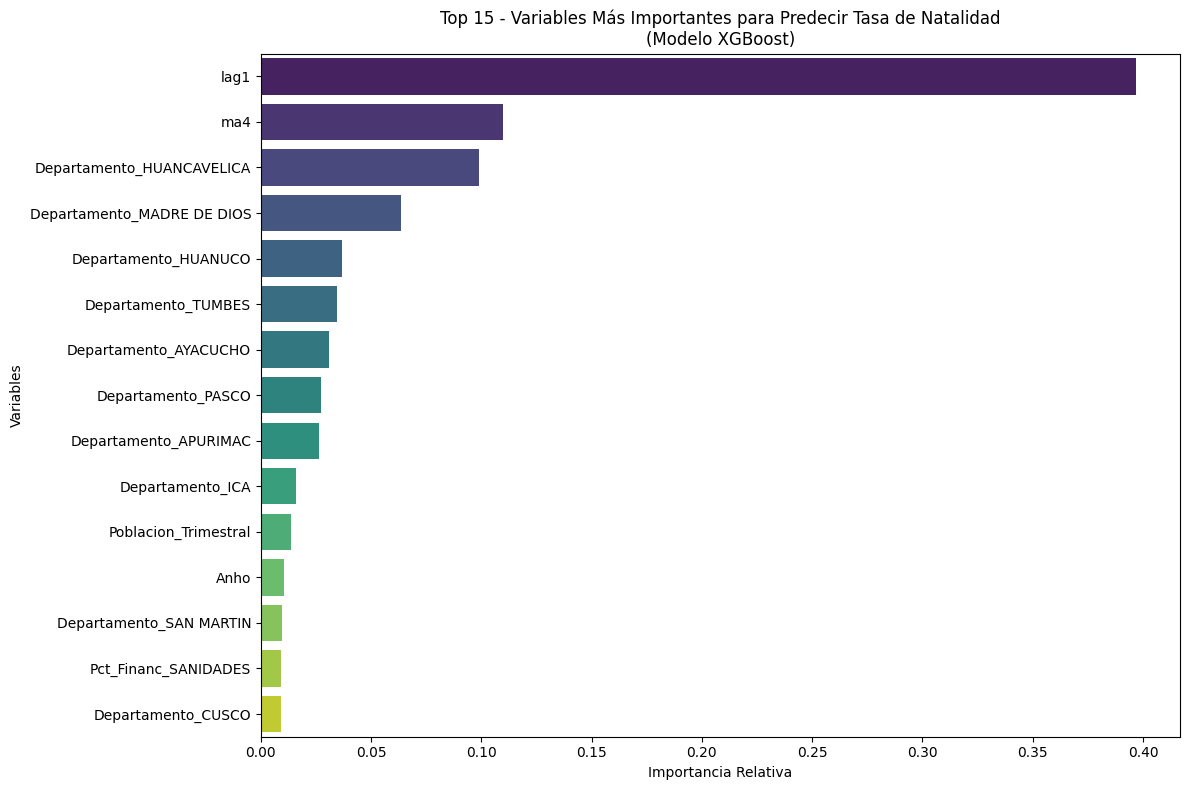

In [ ]:
# Visualizar top 15 variables más importantes
plt.figure(figsize=(12, 8))
sns.barplot(data=df_importancia.head(15), y='Variables', x='Importancia', palette='viridis')
plt.title('Top 15 - Variables Más Importantes para Predecir Tasa de Natalidad\n(Modelo XGBoost)')
plt.xlabel('Importancia Relativa')
plt.tight_layout()
plt.show()

In [ ]:
print("TOP 10 VARIABLES MÁS INFLUYENTES:\n")
for i, row in df_importancia.head(10).iterrows():
    print(f"{row['Variables']}: {row['Importancia']:.4f}")

TOP 10 VARIABLES MÁS INFLUYENTES:

lag1: 0.3970
ma4: 0.1098
Departamento_HUANCAVELICA: 0.0988
Departamento_MADRE DE DIOS: 0.0635
Departamento_HUANUCO: 0.0367
Departamento_TUMBES: 0.0346
Departamento_AYACUCHO: 0.0310
Departamento_PASCO: 0.0272
Departamento_APURIMAC: 0.0264
Departamento_ICA: 0.0159


### **8.2. Análisis de importancia por categorías de variables**

In [ ]:
# Clasificar variables en categorías
categorias = {
    'Temporal': ['lag1', 'lag4', 'ma4', 'Anho', 'Trimestre'],
    'Edad_Madre': ['Edad_Media', 'Pct_Adolescentes', 'Pct_Mayores35'],
    'Reproductivo': ['Embarazos_Prom', 'HijosVivos_Prom', 'Abortos_Prom'],
    'Educacion': ['Pct_Nivel_SUPERIOR', 'Pct_Nivel_SECUNDARIA', 'Pct_Nivel_PRIMARIA_BAJA'],
    'Estado_Civil': ['Pct_EstadoCivil_CON_PAREJA'],
    'Atencion_Salud': ['Pct_Lugar_INSTITUCIONAL', 'Pct_Financ_SIS', 'Pct_Financ_ESSALUD',
                      'Pct_Financ_SANIDADES', 'Pct_Financ_PRIVADO'],
    'Geografico': [col for col in df_importancia['Variables'] if 'Departamento_' in col]
}

# Calcular importancia por categoría
importancia_categorias = {}
for categoria, vars_categoria in categorias.items():
    importancia_cat = df_importancia[df_importancia['Variables'].isin(vars_categoria)]['Importancia'].sum()
    importancia_categorias[categoria] = importancia_cat

/tmp/ipython-input-278574988.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancia_cat, y='Categoria', x='Importancia', palette='Set2')


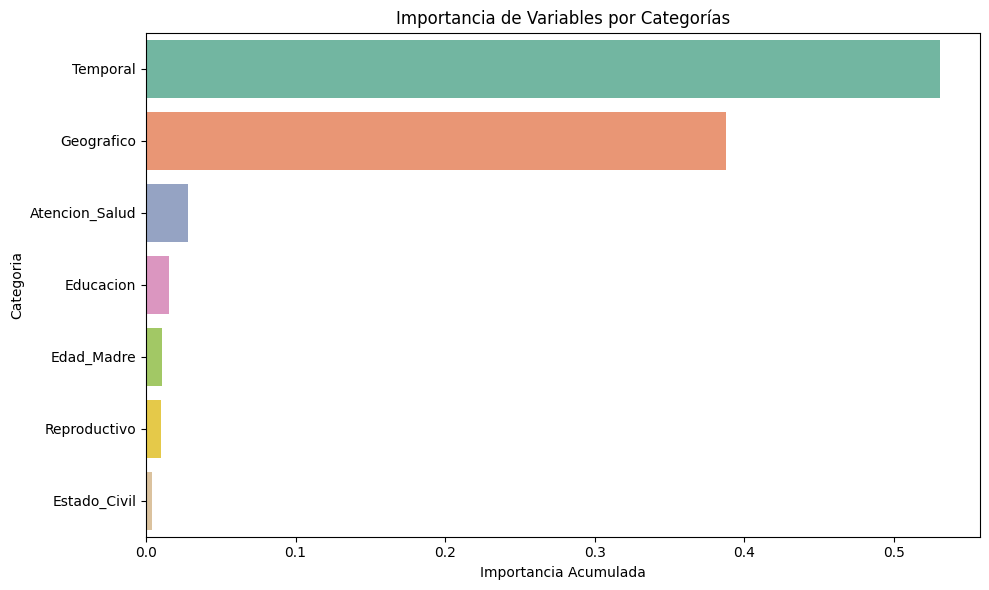

In [ ]:
# Visualizar importancia por categorías
df_importancia_cat = pd.DataFrame({
    'Categoria': list(importancia_categorias.keys()),
    'Importancia': list(importancia_categorias.values())
}).sort_values('Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_importancia_cat, y='Categoria', x='Importancia', palette='Set2')
plt.title('Importancia de Variables por Categorías')
plt.xlabel('Importancia Acumulada')
plt.tight_layout()
plt.show()

In [ ]:
print("IMPORTANCIA POR CATEGORÍAS:\n")
for cat, imp in importancia_categorias.items():
    print(f"{cat}: {imp:.4f}")

IMPORTANCIA POR CATEGORÍAS:

Temporal: 0.5308
Edad_Madre: 0.0104
Reproductivo: 0.0099
Educacion: 0.0152
Estado_Civil: 0.0040
Atencion_Salud: 0.0283
Geografico: 0.3877


### **8.3. Análisis de patrones geográficos**

In [ ]:
# Extraer importancia de variables departamentales
imp_deptos = df_importancia[df_importancia['Caracteristica'].str.contains('Departamento_')].copy()
imp_deptos['Departamento'] = imp_deptos['Caracteristica'].str.replace('Departamento_', '')

print("TOP 10 DEPARTAMENTOS CON MAYOR INFLUENCIA:\n")
for i, row in imp_deptos.head(10).iterrows():
    print(f"{row['Departamento']}: {row['Importancia']:.4f}")

TOP 10 DEPARTAMENTOS CON MAYOR INFLUENCIA:

HUANCAVELICA: 0.0988
MADRE DE DIOS: 0.0635
HUANUCO: 0.0367
TUMBES: 0.0346
AYACUCHO: 0.0310
PASCO: 0.0272
APURIMAC: 0.0264
ICA: 0.0159
SAN MARTIN: 0.0097
CUSCO: 0.0089


/tmp/ipython-input-611394800.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_deptos.head(15), y='Departamento', x='Importancia', palette='coolwarm')


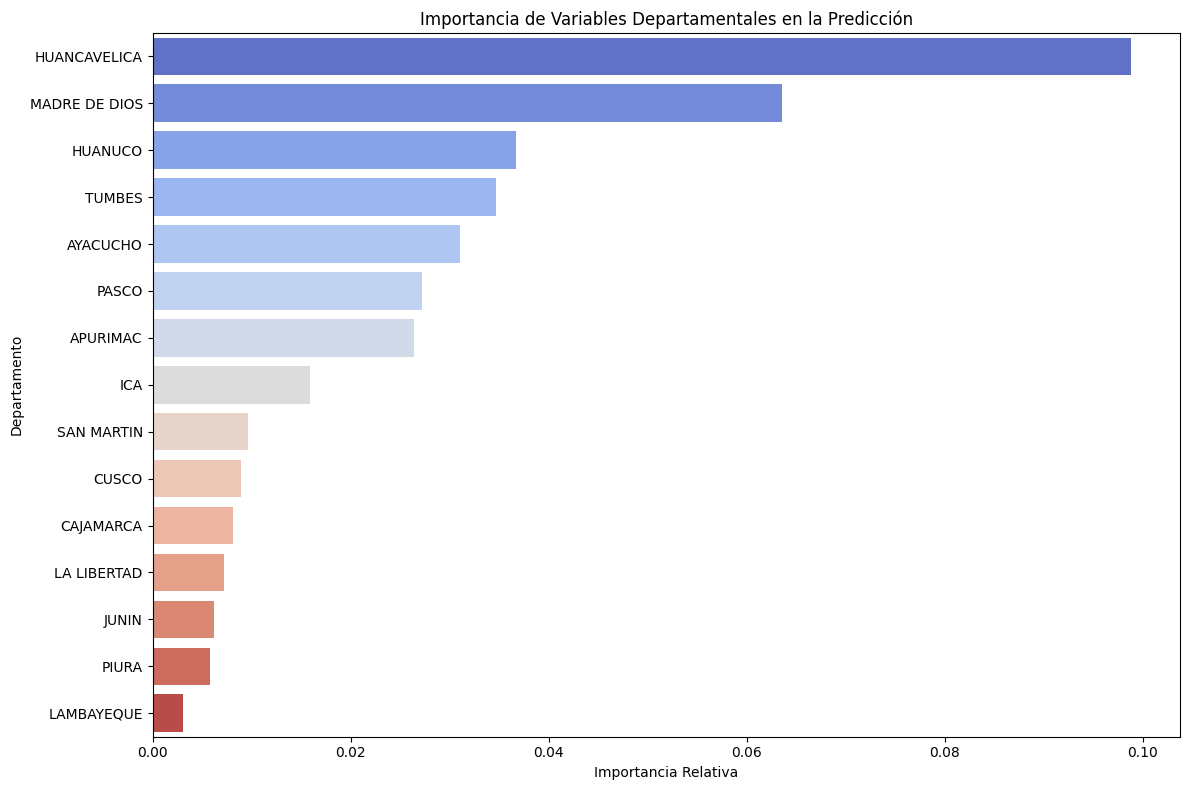

In [ ]:
# Visualizar importancia de departamentos
plt.figure(figsize=(12, 8))
sns.barplot(data=imp_deptos.head(15), y='Departamento', x='Importancia', palette='coolwarm')
plt.title('Importancia de Variables Departamentales en la Predicción')
plt.xlabel('Importancia Relativa')
plt.tight_layout()
plt.show()

### **8.4. Análisis profundo de departamentos clave**

In [ ]:
# Analizar características únicas de los departamentos más influyentes
deptos_clave = ['HUANCAVELICA', 'MADRE DE DIOS', 'AYACUCHO', 'TUMBES', 'HUANUCO']

# Crear dataset filtrado para análisis comparativo
df_deptos_clave = df_final[df_final['Departamento'].isin(deptos_clave)].copy()

In [ ]:
# Calcular promedios nacionales (excluyendo departamentos clave para comparación)
df_otros_deptos = df_final[~df_final['Departamento'].isin(deptos_clave)]
promedio_nacional = df_otros_deptos[['Tasa_Natalidad_Trimestral', 'Edad_Media', 'Pct_Adolescentes',
                                   'Pct_Nivel_SUPERIOR', 'Pct_Financ_SIS']].mean()

# Calcular datos nacionales
print(f"NACIONAL:")
print(f"  - Tasa Natalidad: {promedio_nacional['Tasa_Natalidad_Trimestral']:.2f}")
print(f"  - Edad Media Madre: {promedio_nacional['Edad_Media']:.1f} años")
print(f"  - % Adolescentes: {promedio_nacional['Pct_Adolescentes']:.1%}")
print(f"  - % Educación Superior: {promedio_nacional['Pct_Nivel_SUPERIOR']:.1%}")
print(f"  - % SIS: {promedio_nacional['Pct_Financ_SIS']:.1%}")

print(f"\nPOR DEPARTAMENTO CLAVE:")
# Analizar cada departamento clave
for depto in deptos_clave:
    datos_depto = df_final[df_final['Departamento'] == depto]

    print(f"\n  {depto}:")
    print(f"    - Tasa Natalidad: {datos_depto['Tasa_Natalidad_Trimestral'].mean():.2f}")
    print(f"    - Edad Media Madre: {datos_depto['Edad_Media'].mean():.1f} años")
    print(f"    - % Adolescentes: {datos_depto['Pct_Adolescentes'].mean():.1%}")
    print(f"    - % Educación Superior: {datos_depto['Pct_Nivel_SUPERIOR'].mean():.1%}")
    print(f"    - % SIS: {datos_depto['Pct_Financ_SIS'].mean():.1%}")

    # Calcular volatilidad (desviación estándar de la tasa)
    volatilidad = datos_depto['Tasa_Natalidad_Trimestral'].std()
    print(f"    - Volatilidad Tasa: {volatilidad:.2f} (indicador de variabilidad temporal)")

NACIONAL:
  - Tasa Natalidad: 3.57
  - Edad Media Madre: 28.1 años
  - % Adolescentes: 12.1%
  - % Educación Superior: 32.8%
  - % SIS: 74.0%

POR DEPARTAMENTO CLAVE:

  HUANCAVELICA:
    - Tasa Natalidad: 4.80
    - Edad Media Madre: 26.9 años
    - % Adolescentes: 17.2%
    - % Educación Superior: 21.2%
    - % SIS: 88.8%
    - Volatilidad Tasa: 0.50 (indicador de variabilidad temporal)

  MADRE DE DIOS:
    - Tasa Natalidad: 4.75
    - Edad Media Madre: 28.0 años
    - % Adolescentes: 11.7%
    - % Educación Superior: 25.1%
    - % SIS: 82.1%
    - Volatilidad Tasa: 0.40 (indicador de variabilidad temporal)

  AYACUCHO:
    - Tasa Natalidad: 4.15
    - Edad Media Madre: 27.9 años
    - % Adolescentes: 14.7%
    - % Educación Superior: 28.6%
    - % SIS: 87.7%
    - Volatilidad Tasa: 0.55 (indicador de variabilidad temporal)

  TUMBES:
    - Tasa Natalidad: 3.85
    - Edad Media Madre: 27.3 años
    - % Adolescentes: 14.2%
    - % Educación Superior: 34.3%
    - % SIS: 77.0%
    - Vo

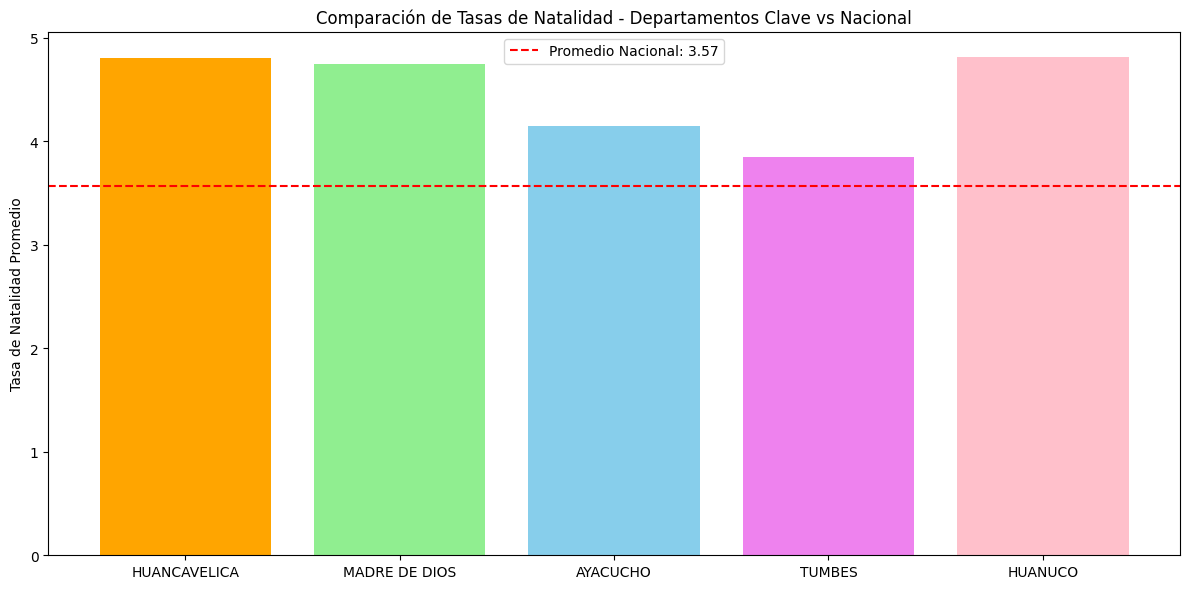

In [ ]:
# Visualizar comparativa de tasas de natalidad
plt.figure(figsize=(12, 6))
deptos_data = []
for depto in deptos_clave:
    deptos_data.append(df_final[df_final['Departamento'] == depto]['Tasa_Natalidad_Trimestral'].mean())

plt.bar(deptos_clave, deptos_data, color=['orange', 'lightgreen', 'skyblue', 'violet', 'pink'])
plt.axhline(y=promedio_nacional['Tasa_Natalidad_Trimestral'], color='red', linestyle='--',
           label=f'Promedio Nacional: {promedio_nacional["Tasa_Natalidad_Trimestral"]:.2f}')
plt.ylabel('Tasa de Natalidad Promedio')
plt.title('Comparación de Tasas de Natalidad - Departamentos Clave vs Nacional')
plt.legend()
plt.tight_layout()
plt.show()

Los departamentos que más influyen en el modelo presentan tasas de natalidad notablemente más altas que el promedio nacional (3.56), especialmente Huancavelica y Huánuco (4.82). Este perfil se relaciona consistentemente con:
*  Madres más jóvenes: hasta 1.2 años menos que el promedio nacional
*  Mayor maternidad adolescente: Huancavelica 17.2% vs 12.1% nacional
*  Menor educación superior: Huancavelica 21.2% vs 32.8% nacional
*  Alta dependencia del SIS: hasta 88.8% en Huancavelica

La fuerte influencia de estos departamentos no solo viene de sus características estructurales, sino también de su mayor variabilidad temporal:
*  Tumbes tiene la mayor volatilidad (0.74) a pesar de indicadores educativos similares al promedio
*  Ayacucho combina alta natalidad con alta variabilidad (0.55)
*  Esta inestabilidad genera "señales más fuertes" para el aprendizaje del modelo

Los departamentos con transiciones demográficas más dinámicas y mayores desigualdades socioeconómicas aportan más información predictiva. Esto indica que la heterogeneidad regional no es ruido, sino una señal valiosa para entender los factores detrás de la natalidad peruana.

Finalmente, emerge un patrón de "departamentos predictores" con economías en transición, acceso limitado a educación superior y sistemas de salud principalmente públicos, que experimentan cambios demográficos acelerados.